# GGD27 / HH80/81 / IRAS18162

# Conclusion:
There are no lines coincident with NaCl.  This is a line-poor source with nothing to stack up on.  CH3CN and other common species are prominently detected.  There's something fairly unique and interesting going on here, but not salt.

References:
 * https://ui.adsabs.harvard.edu/abs/2020ApJ...888...41A/abstract - modeling accretion disk

In [1]:
from astropy import units as u
distance = 1.3*u.kpc

In [2]:
cd /orange/adamginsburg/salt/sanhueza/IRAS18162

/orange/adamginsburg/salt/sanhueza/IRAS18162


In [3]:
ls

cutout2.reg
cutout.reg
I18192_Sanhueza_NaCl_PV_withcolorcurves.png
I18192_Sanhueza_SO_PV_withcolorcurves.png
I18192_Sanhueza_Water_PV_withcolorcurves.png
IRAS_181622048.config8.cont_avg.selfcal_0.5_hogbom.image.fits
IRAS_181622048.config8.spw0.robust0.5.image_co1_smaller.fits
IRAS_181622048.config8.spw0.robust0.5.image_co3_smaller.fits
IRAS_181622048.config8.spw0.robust0.5.image_small.fits
IRAS_181622048.config8.spw1.robust0.5.image_co1_smaller.fits
IRAS_181622048.config8.spw1.robust0.5.image_co3_smaller.fits
IRAS_181622048.config8.spw1.robust0.5.image_small.fits
IRAS_181622048.config8.spw2.robust0.5.image_co1_smaller.fits
IRAS_181622048.config8.spw2.robust0.5.image_co3_smaller.fits
IRAS_181622048.config8.spw2.robust0.5.image_small.fits
IRAS_181622048.config8.spw3.robust0.5.image_co1_smaller.fits
IRAS_181622048.config8.spw3.robust0.5.image_co3_smaller.fits
IRAS_181622048.config8.spw3.robust0.5.image_small.fits
NaCl_v_le_3_stackcube.fits
spectra/


In [4]:
targetname = 'IRAS_181622048'

for fn in glob.glob("*.fits"):
    print('app

In [5]:
%matplotlib inline
import pylab as pl
pl.rcParams['figure.facecolor'] = 'w'
pl.rcParams['image.origin'] = 'lower'
pl.rcParams['font.size'] = 16
from spectral_cube import SpectralCube
from astropy import units as u
from astropy.visualization import quantity_support
quantity_support()

<astropy.visualization.units.quantity_support.<locals>.MplQuantityConverter at 0x2b01ae3bf1f0>

In [6]:
from astropy.table import Table
from astropy import table

In [7]:
import pprint

In [8]:
import scipy, scipy.ndimage

In [9]:
import numpy as np
import os
import glob
from astropy import constants, units as u, table, stats, coordinates, wcs, log, coordinates as coord, visualization
import radio_beam
import pyspeckit
import pylab as pl
from astroquery.splatalogue.utils import minimize_table as mt
import sys
sys.path.append('/orange/adamginsburg/salt/Orion_ALMA_2016.1.00165.S/analysis')
import lines
import paths
from salt_tables import (salt_tables, salt_table_names, SO, SO2, HCl, sis_tables, AlCl, AlF, Al37Cl,
                         NaF, AlO, AlOH, NaCN, CaS, CaO)

In [10]:
import sys
import imp

sys.path.insert(0,'/orange/adamginsburg/salt/Orion_ALMA_2016.1.00165.S/analysis')
import paths
imp.reload(paths) # we need orion's paths loaded

from show_pv import show_pv
import show_pv
imp.reload(show_pv)

from show_pv import show_keplercurves, show_pv

In [11]:
import regions
from astropy import units as u, coordinates
reg = regions.Regions.read('cutout.reg')
#reg2 = regions.Regions.read('cutout2.reg')
#reg3 = regions.Regions.read('cutout3.reg')
#regvsm = regions.Regions.read('verysmall.reg')
#regvvsm = regions.Regions.read('innerdiskbox.reg')

In [12]:
reg[0].center.galactic

<SkyCoord (Galactic): (l, b) in deg
    (10.8413657, -2.59164061)>

(2603.0, 2818.0, 2269.0, 2469.0)

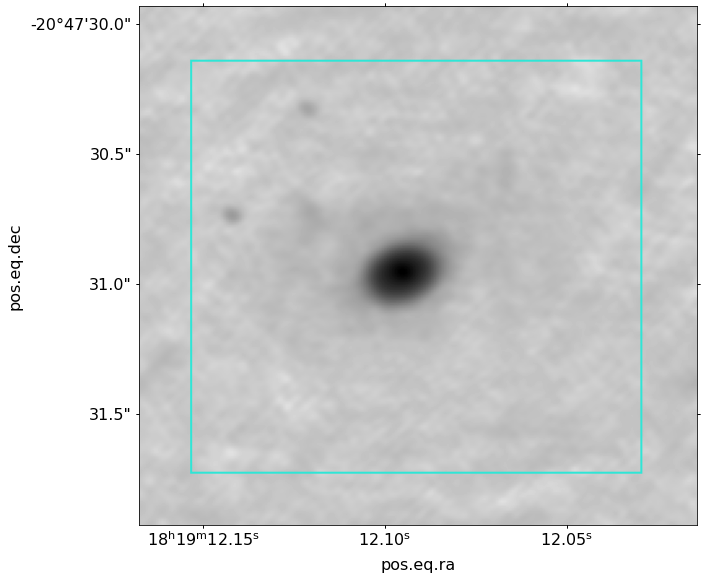

In [13]:
cont = SpectralCube.read('IRAS_181622048.config8.cont_avg.selfcal_0.5_hogbom.image.fits')
pl.figure(figsize=(10,10))
ax = pl.subplot(projection=cont[0].wcs)
ax.imshow(cont[0].value, cmap='gray_r', norm=visualization.simple_norm(cont[0].value, stretch='log'))
reg[0].to_pixel(cont[0].wcs).plot(ax=ax)
#reg2[0].to_pixel(cont[0].wcs).plot(ax=ax)
#reg3[0].to_pixel(cont[0].wcs).plot(ax=ax)
pp = reg[0].to_pixel(cont.wcs.celestial)
bb = pp.bounding_box
ax.axis([bb.ixmin-20, bb.ixmax+20, bb.iymin-20, bb.iymax+20])

# NaCl Stackl

In [14]:
from spectral_cube.analysis_utilities import stack_cube

In [15]:
nacltables = salt_tables[3:5]
#nacltables[0]

In [16]:
import spectral_cube.analysis_utilities
import imp
imp.reload(spectral_cube.analysis_utilities)
from spectral_cube.analysis_utilities import stack_cube

In [17]:
flist = (glob.glob(f'{targetname}.config8.spw[0-3].robust0.5.image_small.fits'))

In [18]:
flist

['IRAS_181622048.config8.spw3.robust0.5.image_small.fits',
 'IRAS_181622048.config8.spw1.robust0.5.image_small.fits',
 'IRAS_181622048.config8.spw2.robust0.5.image_small.fits',
 'IRAS_181622048.config8.spw0.robust0.5.image_small.fits']

In [19]:
#from dask.diagnostics import ProgressBar
#pbar = ProgressBar()
#pbar.register()

import dask
dask.config.set(scheduler='threads', num_workers=8)

In [20]:
for fn in flist:
    for rr,regn in ( (reg, 'co1'), ):
        outfile = fn.replace("_small",f"_{regn}_smaller")
        if not os.path.exists(outfile) or (os.path.exists(outfile) and SpectralCube.read(outfile).unit != u.K):
            cube = SpectralCube.read(fn, use_dask=False).subcube_from_regions(rr)
            cube.allow_huge_operations=True
            #with cube.use_dask_scheduler('threads', num_workers=8):
            cb = cube.beams.common_beam(max_iter=20, max_epsilon=0.01)
            scube = cube.convolve_to(cb).to(u.K)
            scube.write(outfile, overwrite=True)

In [21]:
regn = "co1"
# don't need to subcube b/c reg = cutout = co1
cubes = [SpectralCube.read(fn, use_dask=True)#.subcube_from_regions(reg3)
         for fn in (glob.glob(f'{targetname}.config8.spw[0-3].robust0.5.image_{regn}_smaller.fits'))]
for ii,cube in enumerate(cubes):
    # continuum subtract
    with cube.use_dask_scheduler('threads', num_workers=8):
        cube.allow_huge_operations = True
        cubes[ii] = cube - cube.percentile(25, axis=0)
cubes

[DaskSpectralCube with shape=(3860, 159, 173) and unit=K and chunk size (386, 159, 173):
  n_x:    173  type_x: RA---SIN  unit_x: deg    range:   274.800125 deg:  274.800636 deg
  n_y:    159  type_y: DEC--SIN  unit_y: deg    range:   -20.792144 deg:  -20.791706 deg
  n_s:   3860  type_s: FREQ      unit_s: Hz     range: 216862707361.400 Hz:218747086033.577 Hz,
 DaskSpectralCube with shape=(1930, 159, 173) and unit=K and chunk size (386, 159, 173):
  n_x:    173  type_x: RA---SIN  unit_x: deg    range:   274.800125 deg:  274.800636 deg
  n_y:    159  type_y: DEC--SIN  unit_y: deg    range:   -20.792144 deg:  -20.791706 deg
  n_s:   1930  type_s: FREQ      unit_s: Hz     range: 231062952403.500 Hz:232946842768.170 Hz,
 DaskSpectralCube with shape=(1931, 159, 173) and unit=K and chunk size (609, 159, 173):
  n_x:    173  type_x: RA---SIN  unit_x: deg    range:   274.800125 deg:  274.800636 deg
  n_y:    159  type_y: DEC--SIN  unit_y: deg    range:   -20.792144 deg:  -20.791706 deg
  n_s: 

In [22]:
# only needed for VRSCs
if hasattr(cubes[0], 'beams'):
    beams = radio_beam.Beams(beams=[cube.beams.common_beam(max_iter=20, max_epsilon=0.01) for cube in cubes])
    cb=beams.common_beam()
else:
    beams = radio_beam.Beams(beams=[cube.beam for cube in cubes])
    cb=beams.common_beam()
jtok = cb.jtok(217*u.GHz)

In [23]:
cb

Beam: BMAJ=0.10128964265536967 arcsec BMIN=0.07010411928578207 arcsec BPA=94.61941528320312 deg

In [24]:
(cb.major*distance).to(u.au, u.dimensionless_angles())

<Quantity 131.67653545 AU>

In [25]:
(cb.minor*distance).to(u.au, u.dimensionless_angles())

<Quantity 91.13535507 AU>

In [26]:
linelist = np.concatenate([data['Freq'][(data['vu'] <= 3) &
                                          np.any([((data['Freq'].quantity > cube.spectral_extrema[0]) &
                                                   (data['Freq'].quantity < cube.spectral_extrema[1]))
                                                 for cube in cubes],
                                                 axis=0)].quantity
                             for data in nacltables])
linenames = np.concatenate( [data['Species'][(data['vu'] <= 3) &
                                          np.any([((data['Freq'].quantity > cube.spectral_extrema[0]) &
                                                   (data['Freq'].quantity < cube.spectral_extrema[1]))
                                                 for cube in cubes],
                                                 axis=0)]
                             for data in nacltables] )
(linelist, linenames)

(<Quantity [217.980231, 219.614936, 232.509977, 234.251912] GHz>,
 array(['23Na-35Clv=2-2 J=17-16', '23Na-35Clv=1-1 J=17-16',
        '23Na-35Clv=1-1 J=18-17', '23Na-35Clv=0-0 J=18-17'], dtype='<U24'))

In [27]:
from astropy import log
log.setLevel('INFO')

In [28]:
vcen = 14.5 * u.km/u.s # from Patricio
vcen = 11.8*u.km/u.s # Manuel Fernandez+ : https://arxiv.org/pdf/1107.3176.pdf
vcen = 12.5*u.km/u.s # Anez-Lopez

In [29]:
#log.setLevel('DEBUG')
stack, cutouts = stack_cube(cubes,
                   linelist=linelist,
                   vmin=vcen-25*u.km/u.s,
                   vmax=vcen+25*u.km/u.s,
                   average=np.nanmean,
                   convolve_beam=cb,
                   return_cutouts=True)
#log.setLevel('INFO')
stack.write('NaCl_v_le_3_stackcube.fits', overwrite=True)

In [30]:
stackc = SpectralCube.read('NaCl_v_le_3_stackcube.fits')
stackc

SpectralCube with shape=(75, 159, 173) and unit=K:
 n_x:    173  type_x: RA---SIN  unit_x: deg    range:   274.800125 deg:  274.800636 deg
 n_y:    159  type_y: DEC--SIN  unit_y: deg    range:   -20.792144 deg:  -20.791706 deg
 n_s:     75  type_s: VRAD      unit_s: km / s  range:      -12.380 km / s:      37.317 km / s

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


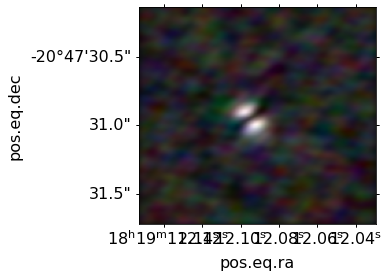

In [31]:
m0b = stackc.spectral_slab(vcen-15*u.km/u.s, vcen-5*u.km/u.s).moment0()
m0g = stackc.spectral_slab(vcen-5*u.km/u.s, vcen+5*u.km/u.s).moment0()
m0r = stackc.spectral_slab(vcen+5*u.km/u.s, vcen+15*u.km/u.s).moment0()
ax = pl.subplot(projection=m0b.wcs.celestial)
rgb = np.array([m0r.value, m0g.value, m0b.value]).swapaxes(0,2).swapaxes(0,1)
rgb /= rgb.max()
ax.imshow(rgb, origin='lower')

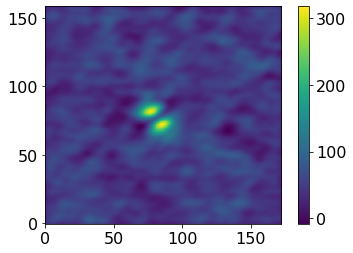

In [32]:
m0r.quicklook()
pl.colorbar()

In [33]:
cont = SpectralCube.read('IRAS_181622048.config8.cont_avg.selfcal_0.5_hogbom.image.fits').to(u.K)
cont

SpectralCube with shape=(1, 5120, 5120) and unit=K:
 n_x:   5120  type_x: RA---SIN  unit_x: deg    range:   274.793222 deg:  274.808433 deg
 n_y:   5120  type_y: DEC--SIN  unit_y: deg    range:   -20.798505 deg:  -20.784286 deg
 n_s:      1  type_s: FREQ      unit_s: Hz     range: 226150027987.200 Hz:226150027987.200 Hz

In [34]:
yc,xc = np.unravel_index(np.nanargmax(cont[0]), cont[0].shape)

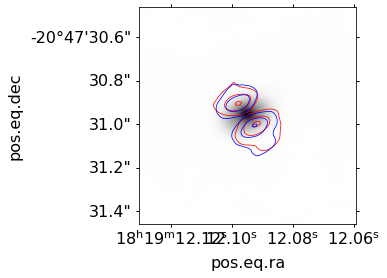

In [35]:
fig = pl.figure()
fig.add_subplot(projection=cont.wcs.celestial)
ax = fig.gca()
ax.imshow(cont[0].value, cmap='gray_r')
#ax.axis((2460,2550,2530,2610))
ax.axis((xc-50,xc+50,yc-50,yc+50))
ax.contour(m0r, colors=['r']*5, levels=[100,200,300], linewidths=[0.75]*5, transform=ax.get_transform(m0r.wcs.celestial))
ax.contour(m0b, colors=['b']*5, levels=[100,200,300], linewidths=[0.75]*5, transform=ax.get_transform(m0b.wcs.celestial))

DaskSpectralCube with shape=(1930, 159, 173) and unit=K and chunk size (386, 159, 173):
 n_x:    173  type_x: RA---SIN  unit_x: deg    range:   274.800125 deg:  274.800636 deg
 n_y:    159  type_y: DEC--SIN  unit_y: deg    range:   -20.792144 deg:  -20.791706 deg
 n_s:   1930  type_s: FREQ      unit_s: Hz     range: 231062952403.500 Hz:232946842768.170 Hz
DaskSpectralCube with shape=(33, 159, 173) and unit=K and chunk size (33, 159, 173):
 n_x:    173  type_x: RA---SIN  unit_x: deg    range:   274.800125 deg:  274.800636 deg
 n_y:    159  type_y: DEC--SIN  unit_y: deg    range:   -20.792144 deg:  -20.791706 deg
 n_s:     33  type_s: VRAD      unit_s: km / s  range:       -8.018 km / s:      32.247 km / s


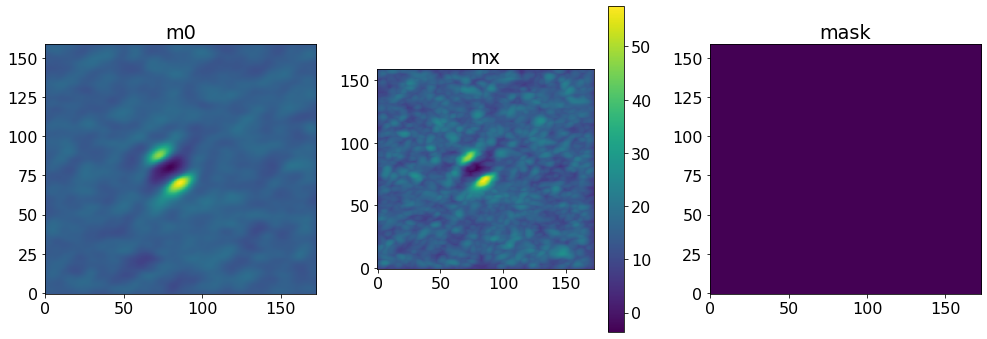

<Figure size 432x288 with 0 Axes>

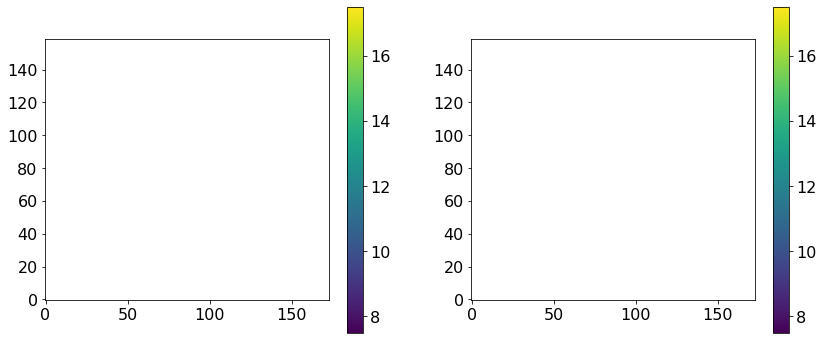

In [36]:
# try creating a vmap based on another line (water)
restval = 232.6867*u.GHz # 'H2Ov2=1_5(5,0)-6(4,3)': 
cube = [c for c in cubes if (c.spectral_extrema[0] < restval) & (c.spectral_extrema[1] > restval)][0]
print(cube)
watercube = scube = (cube.subcube_from_regions(reg)
         .with_spectral_unit(u.km/u.s,
                                                          velocity_convention='radio',
                                                          rest_value=restval)
         .spectral_slab(-20*u.km/u.s+vcen, 20*u.km/u.s+vcen))
print(scube)
pl.figure(figsize=(14,5))
pl.subplot(1,3,1)
m0 = scube.moment0()
m0.quicklook()
pl.title("m0")

pl.subplot(1,3,2)
mx = scube.max(axis=0)
mx.quicklook()
pl.title("mx")
pl.colorbar()
pl.subplot(1,3,3)
msk = mx > 0.04*jtok
#msk = scipy.ndimage.binary_erosion(msk, iterations=1)
msk = scipy.ndimage.binary_dilation(msk, iterations=14)
pl.imshow(msk, interpolation='none', origin='lower')
pl.title('mask')
pl.tight_layout()
pl.figure()


m1 = scube.with_mask(msk).with_mask(scube > 20*u.K).moment1()
pl.figure(figsize=(14,6))
ax1 = pl.subplot(1,2,1)
im = ax1.imshow(m1.value, vmin=vcen.value-5, vmax=vcen.value+5)
pl.colorbar(mappable=im)
mxv = scube.with_mask(msk).argmax_world(axis=0)
pl.subplot(1,2,2)
pl.imshow(mxv.value, vmin=vcen.value-5, vmax=vcen.value+5)
pl.colorbar()


#vmap = m1.hdu
# the rest value selected above was just the line center; we need to assume it's really 32 km/s off
#vmap.data = vmap.data

In [37]:
import pvextractor
center = coordinates.SkyCoord('18h19m12.0955s', '-20:47:30.948', unit=u.deg, frame='icrs')
PA = 113*u.deg
path = pvextractor.Path(coordinates.SkyCoord([center.directional_offset_by(PA, 1.5*u.arcsec), center.directional_offset_by(180*u.deg+PA, 1.5*u.arcsec)]))

In [38]:
pvd_water = pvextractor.extract_pv_slice(watercube, path)

leftmost: 0.00017500000000001398 arcsec
rightmost: 0.000691666666666722 arcsec
endpoints_x = [1.705175   1.74088929] arcsec


divide by zero encountered in true_divide
divide by zero encountered in true_divide
divide by zero encountered in true_divide


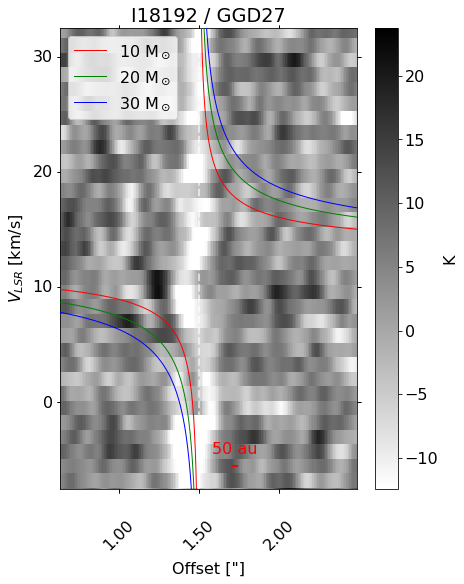

In [39]:
fig,ax,cb,con = show_pv(pvd_water.data, wcs.WCS(pvd_water.header), origin=1.5*u.arcsec, #coordinates.SkyCoord('18:22:26.3857', '-13:30:11.979', unit=(u.hour, u.deg), frame='icrs'),
                vrange=np.array([vcen.value-20, vcen.value+20]), vcen=vcen,
                        imvmin=np.nanpercentile(pvd_water.data, 3), imvmax=np.nanmax(pvd_water.data),
                        distance=1.4*u.kpc,
                        xoffset_label=1.705*u.arcsec
                    )
cb.set_label("K")
kc = show_keplercurves(ax, 1.5*u.arcsec, 1500*u.au, 
                       vcen=vcen,
                               masses=[10,20,30,],
                               linestyles=['-']*4,
                               colors=['r','g','b','c'],
                       radii={},
                       distance=1.4*u.kpc,
                              )
pl.legend(loc='upper left')

pl.title("I18192 / GGD27")
pl.savefig("I18192_Sanhueza_Water_PV_withcolorcurves.png")
#pl.legend(loc='best')

DaskSpectralCube with shape=(3860, 159, 173) and unit=K and chunk size (386, 159, 173):
 n_x:    173  type_x: RA---SIN  unit_x: deg    range:   274.800125 deg:  274.800636 deg
 n_y:    159  type_y: DEC--SIN  unit_y: deg    range:   -20.792144 deg:  -20.791706 deg
 n_s:   3860  type_s: FREQ      unit_s: Hz     range: 219062707499.000 Hz:220947086171.413 Hz
DaskSpectralCube with shape=(61, 159, 173) and unit=K and chunk size (61, 159, 173):
 n_x:    173  type_x: RA---SIN  unit_x: deg    range:   274.800125 deg:  274.800636 deg
 n_y:    159  type_y: DEC--SIN  unit_y: deg    range:   -20.792144 deg:  -20.791706 deg
 n_s:     61  type_s: VRAD      unit_s: km / s  range:       -7.367 km / s:      32.566 km / s


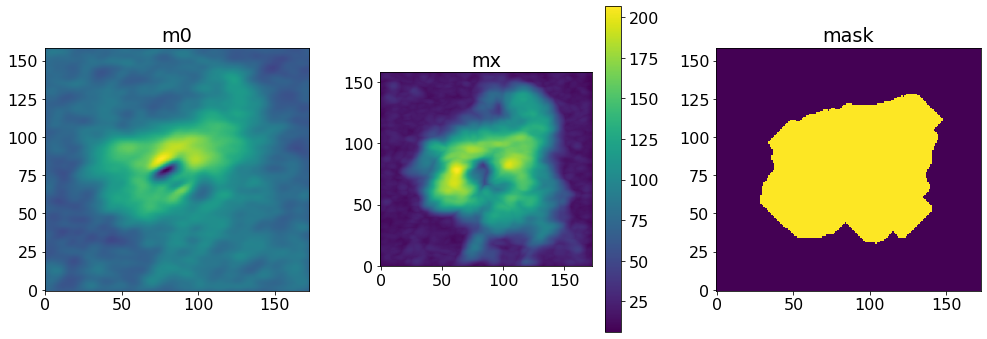

<Figure size 432x288 with 0 Axes>

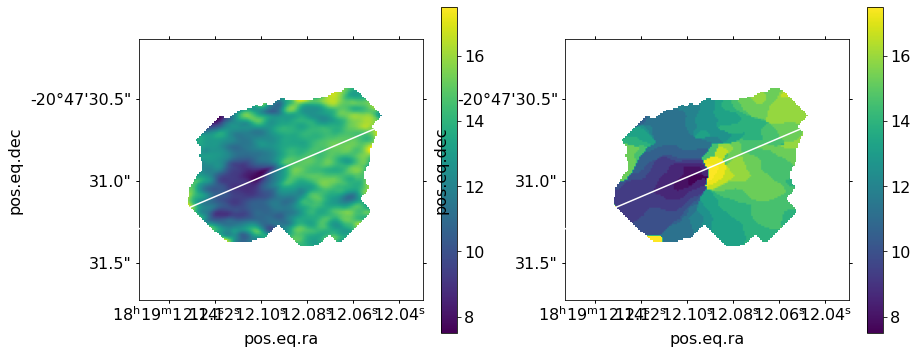

In [40]:
# try creating a vmap based on another line (SO 65-54)
restval = 219.94944000*u.GHz # '': 
cube = [c for c in cubes if (c.spectral_extrema[0] < restval) & (c.spectral_extrema[1] > restval)][0]
print(cube)
socube = scube = (cube.subcube_from_regions(reg)
         .with_spectral_unit(u.km/u.s,
                             velocity_convention='radio',
                             rest_value=restval)
         .spectral_slab(-20*u.km/u.s+vcen, 20*u.km/u.s+vcen))
print(scube)
pl.figure(figsize=(14,5))
pl.subplot(1,3,1)
m0 = scube.moment0()
m0.quicklook()
pl.title("m0")

pl.subplot(1,3,2)
mx = scube.max(axis=0)
mx.quicklook()
pl.title("mx")
pl.colorbar()
pl.subplot(1,3,3)
msk = mx > 130*u.K
#msk = scipy.ndimage.binary_erosion(msk, iterations=1)
msk = scipy.ndimage.binary_dilation(msk, iterations=14)
pl.imshow(msk, interpolation='none', origin='lower')
pl.title('mask')
pl.tight_layout()
pl.figure()


m1 = scube.with_mask(msk).with_mask(scube > 0.0001*jtok).moment1()
pl.figure(figsize=(14,6))
ax1 = pl.subplot(1,2,1, projection=scube.wcs.celestial)
im = ax1.imshow(m1.value, vmin=vcen.value-5, vmax=vcen.value+5)
pl.colorbar(mappable=im)
mxv = scube.with_mask(msk).argmax_world(axis=0)
ax2 = pl.subplot(1,2,2, projection=scube.wcs.celestial)
pl.imshow(mxv.value, vmin=vcen.value-5, vmax=vcen.value+5)
pl.colorbar()
path.show_on_axis(ax1, spacing=1, color='w')
path.show_on_axis(ax2, spacing=1, color='w')


vmap = m1.hdu

In [41]:
pvd_SO = pvextractor.extract_pv_slice(socube, path)

leftmost: 0.00017500000000001398 arcsec
rightmost: 0.000691666666666722 arcsec
endpoints_x = [1.705175   1.74088929] arcsec


divide by zero encountered in true_divide
divide by zero encountered in true_divide
divide by zero encountered in true_divide


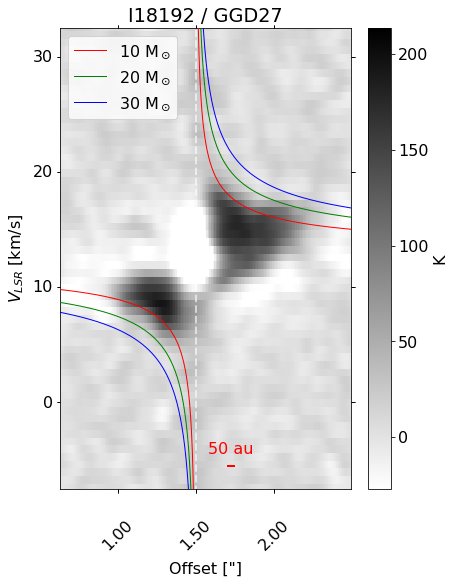

In [42]:
fig,ax,cb,con = show_pv(pvd_SO.data, wcs.WCS(pvd_SO.header), origin=1.5*u.arcsec, #coordinates.SkyCoord('18:22:26.3857', '-13:30:11.979', unit=(u.hour, u.deg), frame='icrs'),
                vrange=np.array([vcen.value-20, vcen.value+20]), vcen=vcen, imvmin=np.nanpercentile(pvd_SO.data, 3), imvmax=np.nanmax(pvd_SO.data),
                        distance=1.4*u.kpc,
                        xoffset_label=1.705*u.arcsec
                    )
cb.set_label("K")
kc = show_keplercurves(ax, 1.5*u.arcsec, 1500*u.au, 
                       vcen=vcen,
                               masses=[10,20,30,],
                               linestyles=['-']*4,
                               colors=['r','g','b','c'],
                       radii={},
                       distance=1.4*u.kpc,
                              )
pl.legend(loc='upper left')

pl.title("I18192 / GGD27")
pl.savefig("I18192_Sanhueza_SO_PV_withcolorcurves.png")
#pl.legend(loc='best')

invalid value encountered in true_divide


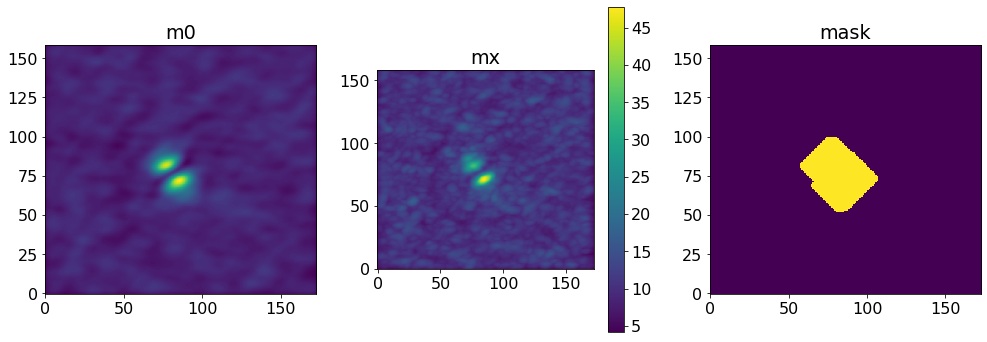

<Figure size 432x288 with 0 Axes>

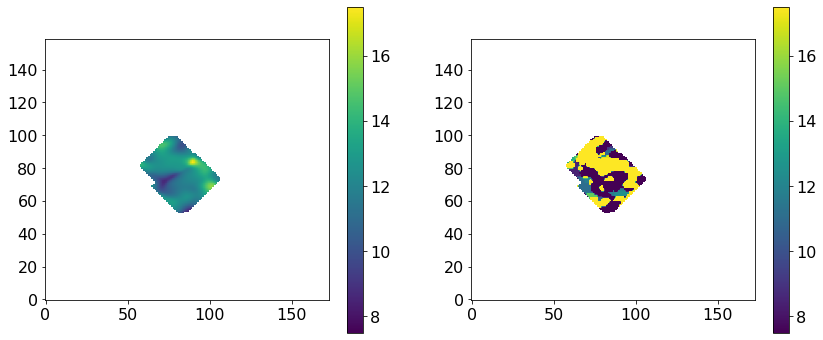

In [43]:
stackc = stackc.subcube_from_regions(reg)
pl.figure(figsize=(14,5))
pl.subplot(1,3,1)
m0 = stackc.moment0()
m0.quicklook()
pl.title("m0")

pl.subplot(1,3,2)
mx = stackc.max(axis=0)
mx.quicklook()
pl.title("mx")
pl.colorbar()
pl.subplot(1,3,3)
msk = mx > 25*u.K
msk = scipy.ndimage.binary_erosion(msk, iterations=1)
msk = scipy.ndimage.binary_dilation(msk, iterations=15)
pl.imshow(msk, interpolation='none', origin='lower')
pl.title('mask')
pl.tight_layout()
pl.figure()


m1 = stackc.with_mask(msk).with_mask(stackc > 0.0001*stackc.unit).moment1()
pl.figure(figsize=(14,6))
ax1 = pl.subplot(1,2,1)
im = ax1.imshow(m1.value, vmin=vcen.value-5, vmax=vcen.value+5)
pl.colorbar(mappable=im)
mxv = stackc.with_mask(msk).argmax_world(axis=0)
pl.subplot(1,2,2)
pl.imshow(mxv.value, vmin=vcen.value-5, vmax=vcen.value+5)
pl.colorbar()


#vmap = m1.hdu

leftmost: 0.00017500000000001398 arcsec
rightmost: 0.000691666666666722 arcsec
endpoints_x = [1.705175   1.74088929] arcsec


divide by zero encountered in true_divide
divide by zero encountered in true_divide
divide by zero encountered in true_divide


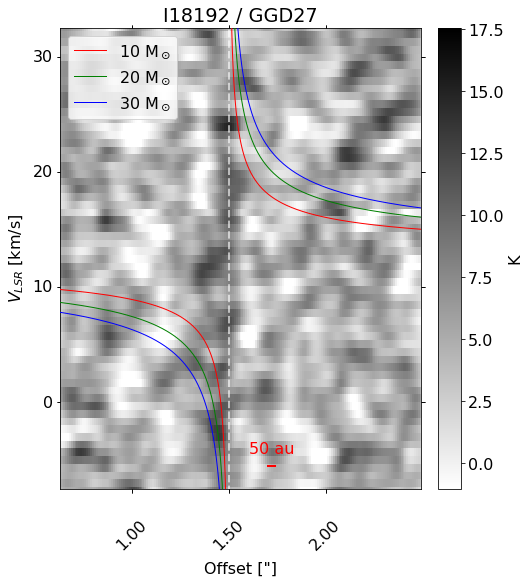

In [44]:
pvd_nacl = pvextractor.extract_pv_slice(stackc, path)

fig,ax,cb,con = show_pv(pvd_nacl.data, wcs.WCS(pvd_nacl.header), origin=1.5*u.arcsec, #coordinates.SkyCoord('18:22:26.3857', '-13:30:11.979', unit=(u.hour, u.deg), frame='icrs'),
                vrange=np.array([vcen.value-20, vcen.value+20]), vcen=vcen, imvmin=np.nanpercentile(pvd_nacl.data, 3), imvmax=np.nanmax(pvd_nacl.data),
                        distance=1.4*u.kpc,
                        xoffset_label=1.705*u.arcsec
                    )
cb.set_label("K")
kc = show_keplercurves(ax, 1.5*u.arcsec, 1500*u.au, 
                       vcen=vcen,
                               masses=[10,20,30,],
                               linestyles=['-']*4,
                               colors=['r','g','b','c'],
                       radii={},
                       distance=1.4*u.kpc,
                              )
pl.legend(loc='upper left')

pl.title("I18192 / GGD27")
pl.savefig("I18192_Sanhueza_NaCl_PV_withcolorcurves.png")
#pl.legend(loc='best')

In [45]:
import sys
sys.path.append('/orange/adamginsburg/salt/code/')
from overplot_saltlines import overplot_saltlines, all_lines
'SO65-54' in all_lines

True

In [46]:
spectra = []
for ii,cube in enumerate(cubes):
    cube.allow_huge_operations=True
    sp = cube.subcube_from_regions(reg).mean(axis=(1,2))
    pysp = pyspeckit.Spectrum(data=sp, xarr=sp.spectral_axis, header=sp.header)
    spectra.append(pysp)
    pysp.specname = f'GGD27 spw{ii} average'

In [47]:
mkdir -p spectra/figures

In [48]:
vcen

<Quantity 12.5 km / s>

In [ ]:
overplot_saltlines(spectra, vcen=vcen, savepath='spectra/figures', ymin=0, ymax=75, yfrac=0.55)

In [50]:
ls -lhrt spectra/figures

total 1.5M
-rw-r--r-- 1 adamginsburg adamginsburg  78K Apr 11 19:48 IRAS_181622048_5_stack.png
-rw-r--r-- 1 adamginsburg adamginsburg  74K Apr 11 19:48 color_labels_IRAS_181622048_5_stack.png
-rw-r--r-- 1 adamginsburg adamginsburg  68K May 17 11:17 IRAS_181622048_spw0_stack.png
-rw-r--r-- 1 adamginsburg adamginsburg  65K May 17 11:17 color_labels_IRAS_181622048_spw0_stack.png
-rw-r--r-- 1 adamginsburg adamginsburg  73K May 17 11:17 IRAS_181622048_spw3_stack.png
-rw-r--r-- 1 adamginsburg adamginsburg  71K May 17 11:17 color_labels_IRAS_181622048_spw3_stack.png
-rw-r--r-- 1 adamginsburg adamginsburg  89K May 17 11:17 IRAS_181622048_spw2_stack.png
-rw-r--r-- 1 adamginsburg adamginsburg  85K May 17 11:17 color_labels_IRAS_181622048_spw2_stack.png
-rw-r--r-- 1 adamginsburg adamginsburg  79K May 17 11:17 IRAS_181622048_spw1_stack.png
-rw-r--r-- 1 adamginsburg adamginsburg  75K May 17 11:17 color_labels_IRAS_181622048_spw1_stack.png
-rw-r--r-- 1 adamginsburg adamginsburg 2.3K May 17 14:56 sty

In [51]:
from IPython.display import Image,display

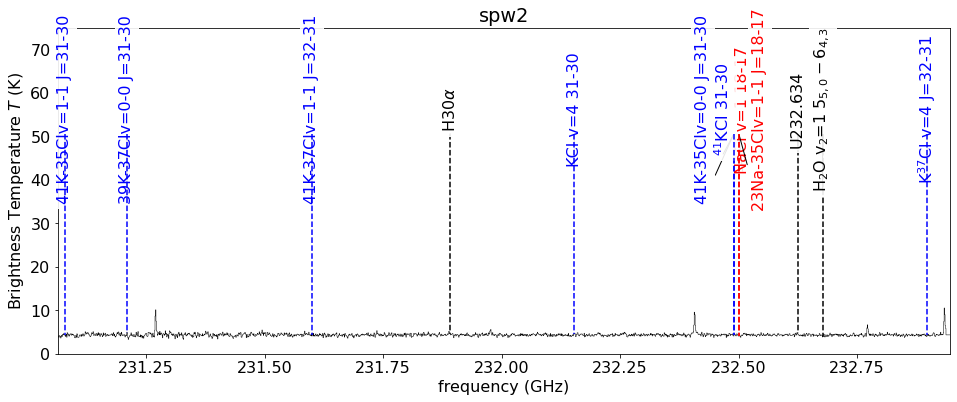

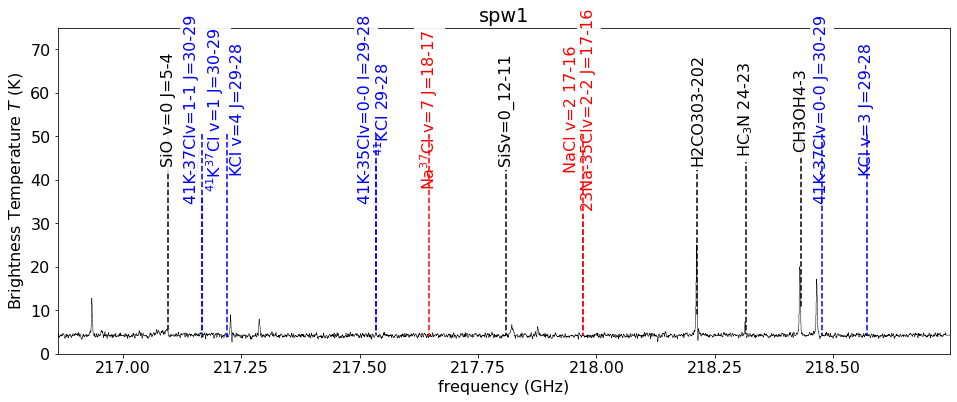

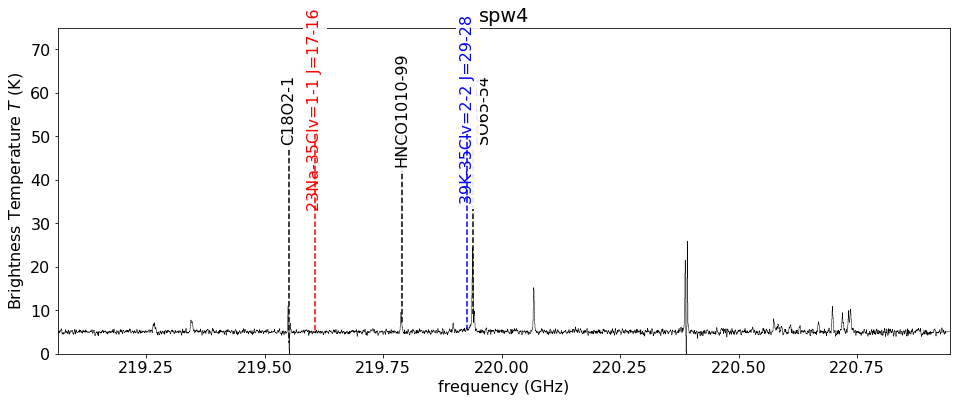

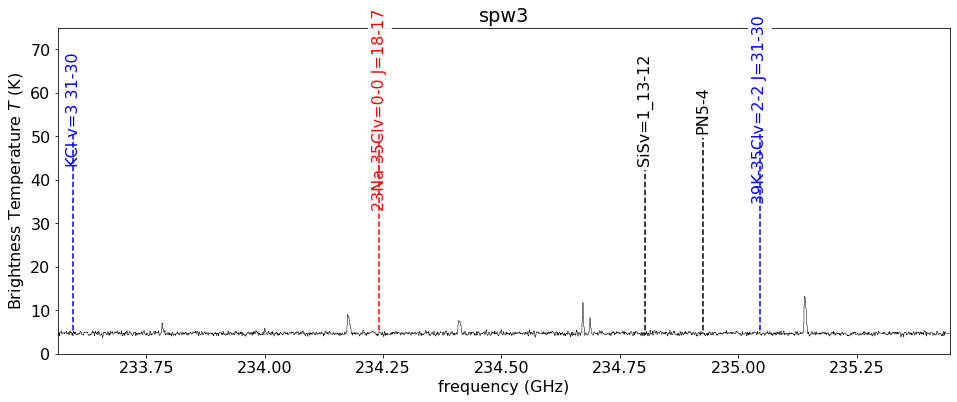

In [52]:
for fn in glob.glob('spectra/figures/color*spw[01234].png'):
    display(Image(fn))

# Attempt to ID lines

<Quantity -14.64582858 km / s>

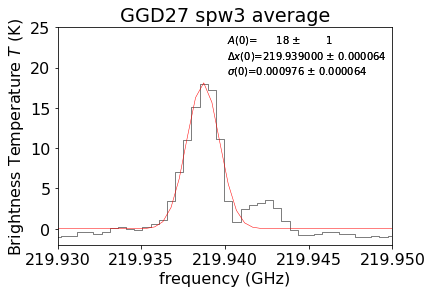

In [53]:
# verify velo w/SO
sp = spectra[3]
lx,ux = 219.93, 219.95
sp.plotter(xmin=lx, xmax=ux)
sp.baseline()
sp.plotter(xmin=lx, xmax=ux)
sp.specfit() #guesses=[5,216.935,0.01], limited=[(True,True),(True,True),(True,True)], limits=[(0,20),(216.93,216.94),(0.0001,0.05)])
sp.baseline(excludefit=True)
sp.plotter(xmin=lx, xmax=ux, ymax=25, ymin=-2)
sp.specfit()
cen = sp.specfit.parinfo['SHIFT0']*sp.xarr.unit
((cen - 219.94944000*u.GHz) / (219.94944000*u.GHz) * constants.c).to(u.km/u.s)
#dx = (10*u.km/u.s / constants.c)*cen
#Splatalogue.query_lines(cen-dx, cen+dx, line_lists=['CDMS'], energy_max=1000, energy_type='eu_k')

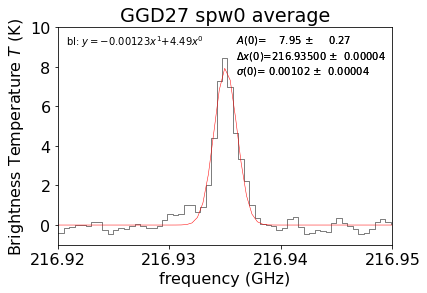

In [54]:
sp = spectra[0]
sp.plotter(xmax=216.95, xmin=216.92)
sp.baseline()
sp.plotter(xmax=216.95, xmin=216.92, ymin=-1, ymax=10)
sp.specfit(guesses=[5,216.935,0.01], limited=[(True,True),(True,True),(True,True)], limits=[(0,20),(216.93,216.94),(0.0001,0.05)])
sp.baseline(excludefit=True)
sp.specfit(guesses=[5,216.935,0.01], limited=[(True,True),(True,True),(True,True)], limits=[(0,20),(216.93,216.94),(0.0001,0.05)])
# CH3OHvt=0-2	Methanol	216.945521

In [55]:
from astroquery.splatalogue import Splatalogue

In [56]:
cen = sp.specfit.parinfo['SHIFT0']*sp.xarr.unit * (1 + vcen/constants.c)
dx = (5*u.km/u.s / constants.c)*cen
Splatalogue.query_lines(cen-dx, cen+dx, line_lists=['CDMS'], energy_max=1000, energy_type='eu_k')

Species,Chemical Name,"Freq-GHz(rest frame,redshifted)","Freq Err(rest frame,redshifted)","Meas Freq-GHz(rest frame,redshifted)","Meas Freq Err(rest frame,redshifted)",Resolved QNs,CDMS/JPL Intensity,S<sub>ij</sub>&#956;<sup>2</sup> (D<sup>2</sup>),S<sub>ij</sub>,Log<sub>10</sub> (A<sub>ij</sub>),Lovas/AST Intensity,E_L (cm^-1),E_L (K),E_U (cm^-1),E_U (K),Upper State Degeneracy,Linelist
str19,str37,float64,float64,float64,float64,str28,float64,float64,float64,float64,int64,float64,float64,float64,float64,float64,str4
13CH3CH213CN,Ethyl cyanide,216.9405333,3.1e-06,--,--,"55(6,49)-54(7,48)",-4.9373,13.79459,0.0,-4.83066,--,468.9045,674.65337,476.14086,685.06494,111.0,CDMS
c-C6H5CHO,Benzaldehyde,216.940549,7e-06,--,--,"78(49,29)-77(49,28)",-4.577,398.99284,0.0,-3.51998,--,586.0829,843.24805,593.31926,853.65962,157.0,CDMS
c-C6H5CHO,Benzaldehyde,216.940549,7e-06,--,--,"78(49,30)-77(49,29)",-4.577,398.99284,0.0,-3.51998,--,586.0829,843.24805,593.31926,853.65962,157.0,CDMS
"n-C3H7CN,v=0","n-Butyronitrile, gauche/anti combined",--,--,216.94059,5e-05,"36(11,26)-35(11,25),gauche",-4.3918,699.10318,0.0,-3.24485,--,154.6754,222.54485,161.91176,232.95642,146.0,CDMS
c-C6H5COCH3,Anisole,216.9406546,1.13e-05,--,--,"87(31,56)-87(30,57)",-5.2473,48.77976,0.0,-4.47984,--,466.4915,671.18158,473.72786,681.59316,175.0,CDMS
c-C6H5COCH3,Anisole,216.9406546,1.13e-05,--,--,"87(31,57)-87(30,58)",-5.2473,48.77976,0.0,-4.47984,--,466.4915,671.18158,473.72786,681.59316,175.0,CDMS
13CN,Cyanide Radical,216.9408757,0.0001868,--,--,"N=2-1,J=3/2-1/2,F1=2-0,F=1-1",-6.8772,0.00061,0.0,-7.61881,--,3.6354,5.2305,10.87177,15.64196,3.0,CDMS
CH2(OD)CHO,Glycolaldehyde,216.9416985,6.4e-06,--,--,"34(9,25)-33(10,24)",-4.2668,22.30955,0.0,-4.41539,--,255.6058,367.76212,262.8422,378.17375,69.0,CDMS
"n-C3H7CN,v=0","n-Butyronitrile, gauche/anti combined",--,--,216.94174,5e-05,"36(11,25)-35(11,24),gauche",-4.3918,699.09584,0.0,-3.24485,--,154.6754,222.54485,161.9118,232.95648,146.0,CDMS


Species,Chemical Name,"Freq-GHz(rest frame,redshifted)","Freq Err(rest frame,redshifted)","Meas Freq-GHz(rest frame,redshifted)","Meas Freq Err(rest frame,redshifted)",Resolved QNs,CDMS/JPL Intensity,S<sub>ij</sub>&#956;<sup>2</sup> (D<sup>2</sup>),S<sub>ij</sub>,Log<sub>10</sub> (A<sub>ij</sub>),Lovas/AST Intensity,E_L (cm^-1),E_L (K),E_U (cm^-1),E_U (K),Upper State Degeneracy,Linelist
str6,str16,float64,float64,float64,float64,str11,float64,float64,float64,float64,int64,float64,float64,float64,float64,float64,str4
DCNv=0,Hydrogen Cyanide,--,--,217.236999,2.1e-06,"J=3-2,F=3-3",-2.8191,2.98154,0.333,-4.29392,--,7.2464,10.42589,14.49265,20.85157,7.0,CDMS
DCNv=0,Hydrogen Cyanide,--,--,217.2383,2.1e-06,"J=3-2,F=2-1",-2.0867,16.10035,1.8,-3.41539,--,7.2465,10.42604,14.49279,20.85177,5.0,CDMS
DCNv=0,Hydrogen Cyanide,217.2385378,0.003379,--,--,J=3-2,-1.3877,80.50709,9.0,-3.33964,--,7.2464,10.42589,14.4927,20.85164,21.0,CDMS
DCNv=0,Hydrogen Cyanide,--,--,217.238555,2.1e-06,"J=3-2,F=3-2",-1.916,23.85251,2.667,-3.39082,--,7.2464,10.42589,14.4927,20.85164,7.0,CDMS
DCNv=0,Hydrogen Cyanide,--,--,217.238612,2.1e-06,"J=3-2,F=4-3",-1.7557,34.50117,3.857,-3.33966,--,7.2464,10.42589,14.4927,20.85164,9.0,CDMS
DCNv=0,Hydrogen Cyanide,--,--,217.239079,2.1e-06,"J=3-2,F=2-3",-4.3631,0.0852,0.01,-5.69179,--,7.2464,10.42589,14.49272,20.85167,5.0,CDMS


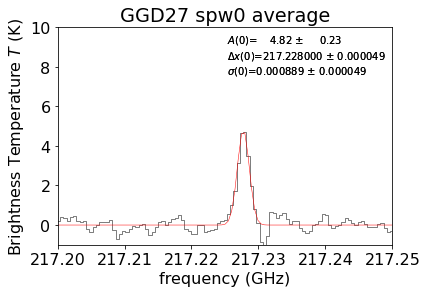

In [57]:
sp = spectra[0]
lx,ux = 217.2, 217.25
sp.plotter(xmin=lx, xmax=ux)
sp.baseline()
sp.plotter(xmin=lx, xmax=ux)
sp.specfit() #guesses=[5,216.935,0.01], limited=[(True,True),(True,True),(True,True)], limits=[(0,20),(216.93,216.94),(0.0001,0.05)])
sp.baseline(excludefit=True)
sp.plotter(xmin=lx, xmax=ux)
sp.specfit()
cen = sp.specfit.parinfo['SHIFT0']*sp.xarr.unit * (1 + vcen/constants.c)
dx = (5*u.km/u.s / constants.c)*cen
Splatalogue.query_lines(cen-dx, cen+dx, line_lists=['CDMS'], energy_max=1000, energy_type='eu_k', chemical_name='DCN')
# DCN 217.238555

Species,Chemical Name,"Freq-GHz(rest frame,redshifted)","Freq Err(rest frame,redshifted)","Meas Freq-GHz(rest frame,redshifted)","Meas Freq Err(rest frame,redshifted)",Resolved QNs,CDMS/JPL Intensity,S<sub>ij</sub>&#956;<sup>2</sup> (D<sup>2</sup>),S<sub>ij</sub>,Log<sub>10</sub> (A<sub>ij</sub>),Lovas/AST Intensity,E_L (cm^-1),E_L (K),E_U (cm^-1),E_U (K),Upper State Degeneracy,Linelist
str19,str42,float64,float64,float64,float64,str28,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,str4
NCC(O)NH2,Cyanoformamide,217.2943909,7.97e-05,--,--,"63(19,44)-62(20,43)",-4.6629,85.48313,7.266,-4.09484,--,590.4824,849.56757,597.73056,859.996,127.0,CDMS
13CN,Cyanide Radical,--,--,217.29447,8e-05,"N=2-1,J=5/2-3/2,F1=2-2,F=1-1",-4.0433,0.41293,0.196,-4.78416,--,3.6481,5.24877,10.89626,15.6772,3.0,CDMS
DCCCHO,Propynal,217.2948186,4.66e-05,--,--,"25(14,11)-24(14,10)",-3.9368,95.4955,0.0,-3.6505,--,483.8649,696.17819,491.11307,706.60676,51.0,CDMS
DCCCHO,Propynal,217.2948186,4.66e-05,--,--,"25(14,12)-24(14,11)",-3.9368,95.4955,0.0,-3.6505,--,483.8649,696.17819,491.11307,706.60676,51.0,CDMS
C2H3OCHO,Vinyl formate,--,--,217.295093,2e-05,"37(3,35)-36(3,34)",-3.9652,44.37592,0.0,-4.15083,--,137.0414,197.17329,144.28958,207.60188,75.0,CDMS
NCC(O)NH2,Cyanoformamide,217.2952497,1.9e-05,--,--,"58(15,44)-58(13,45)",-5.4009,9.3171,0.792,-5.02182,--,482.6503,694.42213,489.89849,704.85059,117.0,CDMS
CH3CHNH2COOH-II,&alpha;-Alanine,217.2955311,0.0004247,--,--,"26(17,10)-25(16,9)",-4.3799,85.67646,0.0,-4.19145,--,79.7142,114.6917,86.9624,125.12031,159.0,CDMS
CH3CHNH2COOH-II,&alpha;-Alanine,217.2955741,0.0004247,--,--,"26(17,9)-25(16,10)",-4.3799,85.67642,0.0,-4.19145,--,79.7142,114.6917,86.9624,125.12031,159.0,CDMS
HCCCH2NH2,Propargylamine,217.2963938,3.93e-05,--,--,"66(7,60)-65(8,57)",-6.1569,2.18909,0.0,-5.7065,--,681.3811,980.35671,688.62928,990.78523,133.0,CDMS


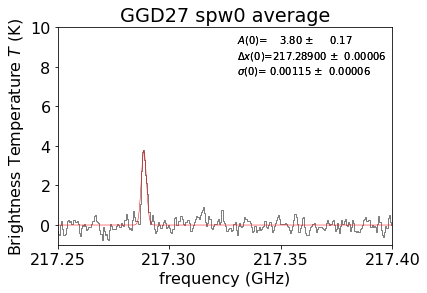

In [58]:
sp = spectra[0]
lx,ux = 217.25, 217.4
sp.plotter(xmin=lx, xmax=ux)
sp.baseline()
sp.plotter(xmin=lx, xmax=ux)
sp.specfit() #guesses=[5,216.935,0.01], limited=[(True,True),(True,True),(True,True)], limits=[(0,20),(216.93,216.94),(0.0001,0.05)])
sp.baseline(excludefit=True)
sp.plotter(xmin=lx, xmax=ux)
sp.specfit()
cen = sp.specfit.parinfo['SHIFT0']*sp.xarr.unit * (1 + vcen/constants.c)
dx = (5*u.km/u.s / constants.c)*cen
Splatalogue.query_lines(cen-dx, cen+dx, line_lists=['CDMS'], energy_max=1000, energy_type='eu_k',)


IRAS_181622048.config8.spw2.robust0.5.image_co1_smaller
DaskSpectralCube with shape=(3860, 159, 173) and unit=K and chunk size (386, 159, 173):
 n_x:    173  type_x: RA---SIN  unit_x: deg    range:   274.800125 deg:  274.800636 deg
 n_y:    159  type_y: DEC--SIN  unit_y: deg    range:   -20.792144 deg:  -20.791706 deg
 n_s:   3860  type_s: FREQ      unit_s: Hz     range: 216862707361.400 Hz:218747086033.577 Hz
Mean spectrum
rms=0.3029577426765955 K
Stacking
IRAS_181622048.config8.spw1.robust0.5.image_co1_smaller
DaskSpectralCube with shape=(1930, 159, 173) and unit=K and chunk size (386, 159, 173):
 n_x:    173  type_x: RA---SIN  unit_x: deg    range:   274.800125 deg:  274.800636 deg
 n_y:    159  type_y: DEC--SIN  unit_y: deg    range:   -20.792144 deg:  -20.791706 deg
 n_s:   1930  type_s: FREQ      unit_s: Hz     range: 231062952403.500 Hz:232946842768.170 Hz


Mean spectrum
rms=0.2541047085296872 K
Stacking
IRAS_181622048.config8.spw0.robust0.5.image_co1_smaller
DaskSpectralCube with shape=(1931, 159, 173) and unit=K and chunk size (609, 159, 173):
 n_x:    173  type_x: RA---SIN  unit_x: deg    range:   274.800125 deg:  274.800636 deg
 n_y:    159  type_y: DEC--SIN  unit_y: deg    range:   -20.792144 deg:  -20.791706 deg
 n_s:   1931  type_s: FREQ      unit_s: Hz     range: 233562952559.900 Hz:235447819539.467 Hz


Mean spectrum
rms=0.271230404198885 K
Stacking
IRAS_181622048.config8.spw3.robust0.5.image_co1_smaller
DaskSpectralCube with shape=(3860, 159, 173) and unit=K and chunk size (386, 159, 173):
 n_x:    173  type_x: RA---SIN  unit_x: deg    range:   274.800125 deg:  274.800636 deg
 n_y:    159  type_y: DEC--SIN  unit_y: deg    range:   -20.792144 deg:  -20.791706 deg
 n_s:   3860  type_s: FREQ      unit_s: Hz     range: 219062707499.000 Hz:220947086171.413 Hz
Mean spectrum
rms=0.34316395925971244 K
Stacking


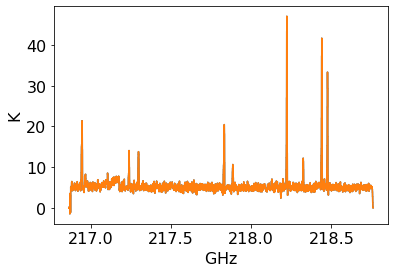

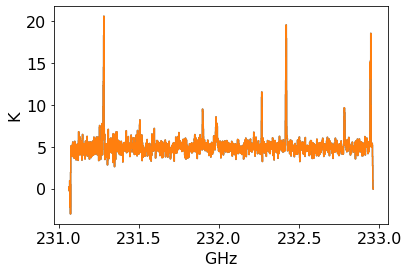

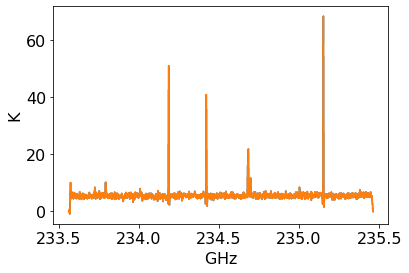

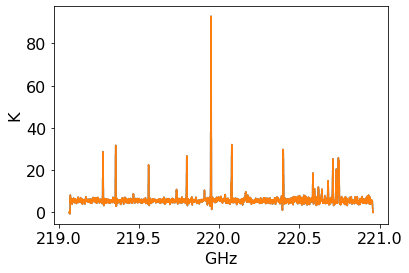

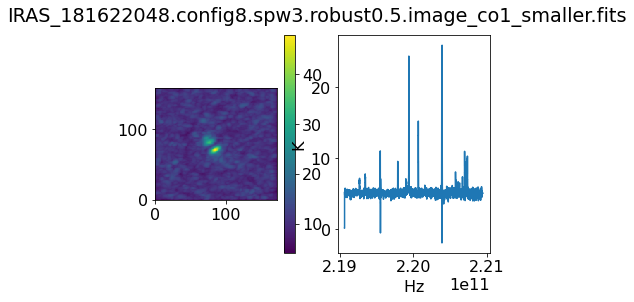

In [60]:
import glob
import spectral_cube.analysis_utilities
import reproject
from tqdm.notebook import tqdm
from astropy import stats
from astropy.io import fits

cbflist = (glob.glob(f'{targetname}.config8.spw[0-3].robust0.5.image_co1_smaller.fits'))
for fn in cbflist:
    basename = os.path.split(fn)[-1].split(".fits")[0]
    print(basename)
    try:
        cube = SpectralCube.read(fn, use_dask=True)
    except Exception as ex:
        print(ex)
        continue
    print(cube)
    scube = cube.subcube_from_regions(reg)
    scube.allow_huge_operations=True
    # continuum subtract before stacking
    scube = scube - scube.percentile(25, axis=0)
    #mx = scube.max(axis=0)
    #msk = mx > 0.003*mx.unit
    print("Mean spectrum")
    sp = scube.mean(axis=(1,2))
    rms = stats.mad_std(sp)
    print(f"rms={rms}")
    
    sp.write(f'spectra/{fn.split("/")[-1].replace(".fits","_meanspec.fits")}', overwrite=True)


    # reproject the velocity map into the cube's coordinate system
    vmap_proj,_ = reproject.reproject_interp(vmap,
                                             scube.wcs.celestial,
                                             shape_out=scube.shape[1:])
    fits.PrimaryHDU(data=vmap_proj, header=scube.wcs.celestial.to_header()).writeto('vmap_GGD27.fits', overwrite=True)
    
    vmap_proj = u.Quantity(vmap_proj, u.km/u.s)
    # convert to km/s with arbitrary rest value so 0 km/s can be interpreted
    if scube.spectral_axis.unit.is_equivalent(u.Hz):
        scube = scube.with_spectral_unit(u.km/u.s, velocity_convention='radio', rest_value=scube.spectral_axis.mean())

    print("Stacking")
    # perform the stacking!
    stack = spectral_cube.analysis_utilities.stack_spectra(scube, vmap_proj,
                                                           v0=0.0*u.km/u.s,
                                                           #progressbar=tqdm,
                                                           #num_cores=8
                                                          )
    fstack = stack.with_spectral_unit(u.GHz)

    pl.suptitle(f"{fn}")
    fstack.write(f'spectra/{basename}_stack.fits', overwrite=True)

    pl.clf()
    fstack.quicklook(filename=f'spectra/figures/{basename}_stack.pdf')
    fstack.quicklook(filename=f'spectra/figures/{basename}_stack.png')
    
    
    fig = pl.figure()
    mappable = pl.subplot(1,2,1).imshow(mx.value, origin='lower', interpolation='none')
    pl.colorbar(mappable)
    pl.subplot(1,2,2)
    pl.suptitle(fn)
    sp.quicklook()

In [61]:
ls spectra

figures/
IRAS_181622048.config8.spw0.robust0.5.image_co1_smaller_meanspec.fits
IRAS_181622048.config8.spw0.robust0.5.image_co1_smaller_stack.fits
IRAS_181622048.config8.spw1.robust0.5.image_co1_smaller_meanspec.fits
IRAS_181622048.config8.spw1.robust0.5.image_co1_smaller_stack.fits
IRAS_181622048.config8.spw2.robust0.5.image_co1_smaller_meanspec.fits
IRAS_181622048.config8.spw2.robust0.5.image_co1_smaller_stack.fits
IRAS_181622048.config8.spw3.robust0.5.image_co1_smaller_meanspec.fits
IRAS_181622048.config8.spw3.robust0.5.image_co1_smaller_stack.fits


In [63]:
from astropy.stats import mad_std

In [64]:
stackspectra = []
for ii,fn in enumerate(glob.glob('spectra/*_stack.fits')):
    pysp = pyspeckit.Spectrum(fn)
    basename = os.path.basename(fn)
    spl = basename.split(".")
    pysp.specname = f'GGD27 {spl[2]} stack'
    stackspectra.append(pysp)
    print(pysp.specname, mad_std(pysp.data))

GGD27 spw0 stack 0.6696215616491747
GGD27 spw3 stack 0.7858089986906639
GGD27 spw2 stack 0.6651050128172001
GGD27 spw1 stack 0.583703604670632


GGD27_spw0_stack
GGD27_spw3_stack
GGD27_spw2_stack
GGD27_spw1_stack


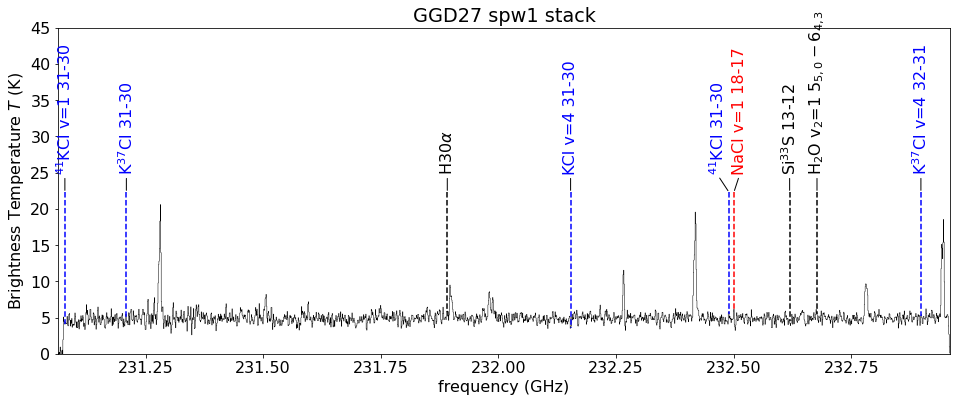

In [65]:
overplot_saltlines(stackspectra, vcen=vcen, savepath='spectra/figures', ymin=0, ymax=45, yfrac=0.55)

In [66]:
pwd

'/orange/adamginsburg/salt/sanhueza/IRAS18162'

In [67]:
ls spectra/figures/

color_labels_GGD27_spw0_average.png
color_labels_GGD27_spw0_stack.png
color_labels_GGD27_spw1_average.png
color_labels_GGD27_spw1_stack.png
color_labels_GGD27_spw2_average.png
color_labels_GGD27_spw2_stack.png
color_labels_GGD27_spw3_average.png
color_labels_GGD27_spw3_stack.png
color_labels_IRAS_181622048_5_stack.png
color_labels_IRAS_181622048_spw0_stack.png
color_labels_IRAS_181622048_spw1_stack.png
color_labels_IRAS_181622048_spw2_stack.png
color_labels_IRAS_181622048_spw3_stack.png
color_labels_spw1.png
color_labels_spw2.png
color_labels_spw3.png
color_labels_spw4.png
gallery.html
GGD27_spw0_average.png
GGD27_spw0_stack.png
GGD27_spw1_average.png
GGD27_spw1_stack.png
GGD27_spw2_average.png
GGD27_spw2_stack.png
GGD27_spw3_average.png
GGD27_spw3_stack.png
IRAS_181622048_5_stack.png
IRAS_181622048.config8.spw0.robust0.5.image_co1_smaller_stack.pdf
IRAS_181622048.config8.spw0.robust0.5.image_co1_smaller_stack.png
IRAS_181622048.config8.spw1.robust0.5.image_co1_smaller_stack.pdf
IRAS_1

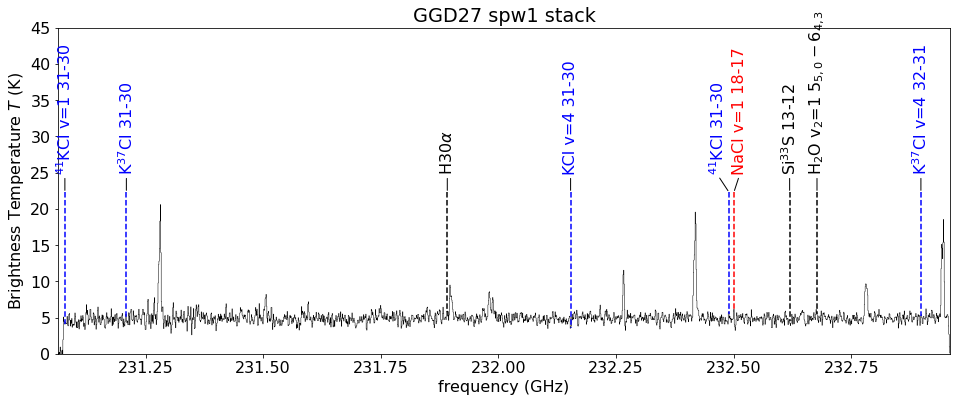

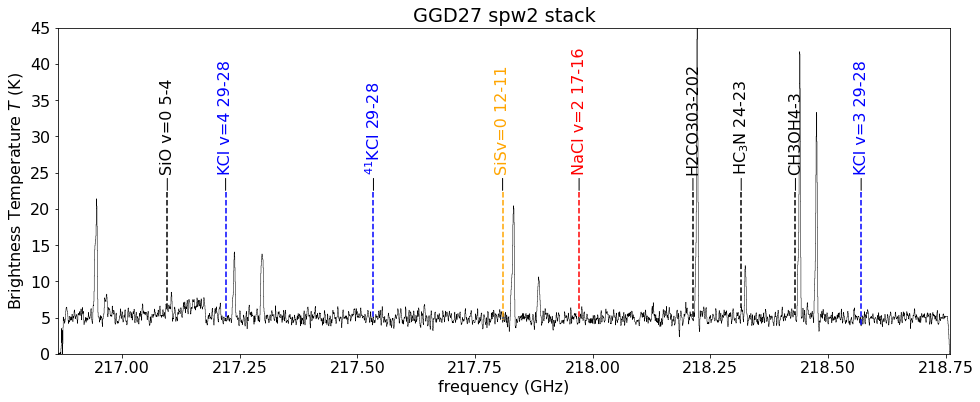

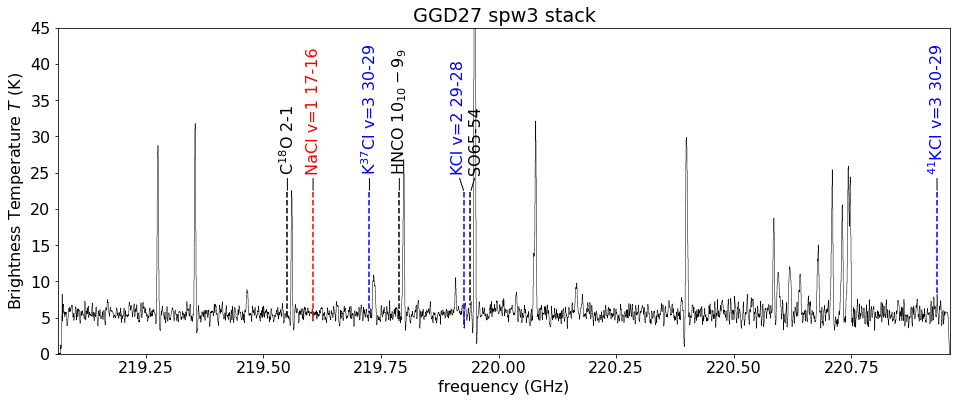

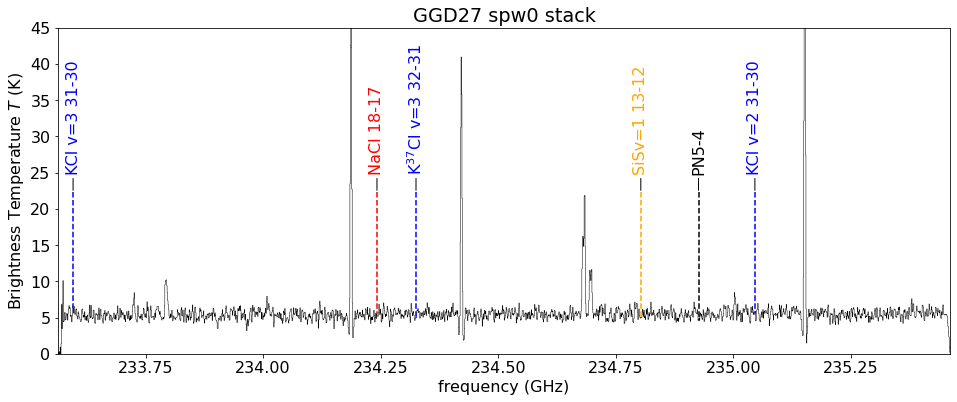

In [90]:
for fn in glob.glob('spectra/figures/color*GGD*stack.png'):
    display(Image(fn))

In [69]:
stackspectra

[<Spectrum object named GGD27 spw0 stack over spectral range 233.56 : 235.46 GHz and flux range = [-0.9, 68.5] K at 0x2b01bc881bb>,
 <Spectrum object named GGD27 spw3 stack over spectral range 219.06 : 220.96 GHz and flux range = [-0.7, 92.9] K at 0x2b01ba0e073>,
 <Spectrum object named GGD27 spw2 stack over spectral range 216.86 : 218.76 GHz and flux range = [-1.5, 47.1] K at 0x2b01c0f7fd6>,
 <Spectrum object named GGD27 spw1 stack over spectral range 231.06 : 232.96 GHz and flux range = [-3.0, 20.6] K at 0x2b01c0f7fee>]

# Attempt to ID lines from stacked spectra

<Quantity 0.00030092 km / s>

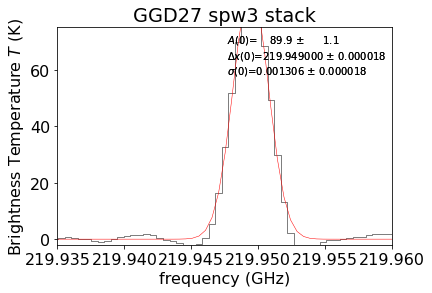

In [70]:
# verify velo w/SO
sp = stackspectra[1]
lx,ux = 219.935, 219.96
sp.plotter()#xmin=lx, xmax=ux)
sp.baseline()
sp.plotter(xmin=lx, xmax=ux)
sp.specfit() #guesses=[5,216.935,0.01], limited=[(True,True),(True,True),(True,True)], limits=[(0,20),(216.93,216.94),(0.0001,0.05)])
sp.plotter(xmin=lx, xmax=ux)
sp.baseline(excludefit=True)
sp.plotter(xmin=lx, xmax=ux, ymax=75, ymin=-2)
sp.specfit()
cen = sp.specfit.parinfo['SHIFT0']*sp.xarr.unit
((cen - 219.94944000*u.GHz) / (219.94944000*u.GHz) * constants.c).to(u.km/u.s)
#dx = (10*u.km/u.s / constants.c)*cen
#Splatalogue.query_lines(cen-dx, cen+dx, line_lists=['CDMS'], energy_max=1000, energy_type='eu_k')

Species,Chemical Name,"Freq-GHz(rest frame,redshifted)","Freq Err(rest frame,redshifted)","Meas Freq-GHz(rest frame,redshifted)","Meas Freq Err(rest frame,redshifted)",Resolved QNs,CDMS/JPL Intensity,S<sub>ij</sub>&#956;<sup>2</sup> (D<sup>2</sup>),S<sub>ij</sub>,Log<sub>10</sub> (A<sub>ij</sub>),Lovas/AST Intensity,E_L (cm^-1),E_L (K),E_U (cm^-1),E_U (K),Upper State Degeneracy,Linelist
str11,str8,float64,float64,int64,int64,str21,float64,float64,float64,float64,int64,float64,float64,float64,float64,float64,str4
CH3OHvt=0-2,Methanol,216.945521,1.2e-05,--,--,"5(-1,4)-4(-2,3)E,vt=0",-4.4932,4.49326,0.0,-4.91591,--,31.5961,45.45948,38.83262,55.87116,44.0,CDMS


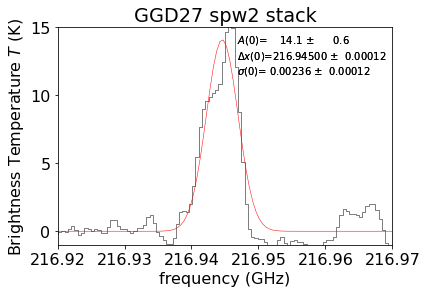

In [71]:
sp = stackspectra[2]
sp.plotter(xmax=216.97, xmin=216.92)
sp.baseline()
sp.plotter(xmax=216.97, xmin=216.92, ymin=-1, ymax=15)
sp.specfit()#guesses=[5,216.935,0.01], limited=[(True,True),(True,True),(True,True)], limits=[(0,20),(216.93,216.94),(0.0001,0.05)])
sp.plotter(xmax=216.97, xmin=216.92, ymin=-1, ymax=15)
sp.baseline(excludefit=True)
sp.plotter(xmax=216.97, xmin=216.92, ymin=-1, ymax=15)
sp.specfit()#guesses=[5,216.935,0.01], limited=[(True,True),(True,True),(True,True)], limits=[(0,20),(216.93,216.94),(0.0001,0.05)])
# CH3OHvt=0-2	Methanol	216.945521
cen = sp.specfit.parinfo['SHIFT0']*sp.xarr.unit# * (1 + vcen/constants.c)
dx = (5*u.km/u.s / constants.c)*cen
Splatalogue.query_lines(cen-dx, cen+dx, line_lists=['CDMS'], energy_max=1000, energy_type='eu_k', chemical_name='Methanol')


Species,Chemical Name,"Freq-GHz(rest frame,redshifted)","Freq Err(rest frame,redshifted)","Meas Freq-GHz(rest frame,redshifted)","Meas Freq Err(rest frame,redshifted)",Resolved QNs,CDMS/JPL Intensity,S<sub>ij</sub>&#956;<sup>2</sup> (D<sup>2</sup>),S<sub>ij</sub>,Log<sub>10</sub> (A<sub>ij</sub>),Lovas/AST Intensity,E_L (cm^-1),E_L (K),E_U (cm^-1),E_U (K),Upper State Degeneracy,Linelist
str6,str16,float64,float64,float64,float64,str11,float64,float64,float64,float64,int64,float64,float64,float64,float64,float64,str4
DCNv=0,Hydrogen Cyanide,--,--,217.236999,2.1e-06,"J=3-2,F=3-3",-2.8191,2.98154,0.333,-4.29392,--,7.2464,10.42589,14.49265,20.85157,7.0,CDMS
DCNv=0,Hydrogen Cyanide,--,--,217.2383,2.1e-06,"J=3-2,F=2-1",-2.0867,16.10035,1.8,-3.41539,--,7.2465,10.42604,14.49279,20.85177,5.0,CDMS
DCNv=0,Hydrogen Cyanide,217.2385378,0.003379,--,--,J=3-2,-1.3877,80.50709,9.0,-3.33964,--,7.2464,10.42589,14.4927,20.85164,21.0,CDMS
DCNv=0,Hydrogen Cyanide,--,--,217.238555,2.1e-06,"J=3-2,F=3-2",-1.916,23.85251,2.667,-3.39082,--,7.2464,10.42589,14.4927,20.85164,7.0,CDMS
DCNv=0,Hydrogen Cyanide,--,--,217.238612,2.1e-06,"J=3-2,F=4-3",-1.7557,34.50117,3.857,-3.33966,--,7.2464,10.42589,14.4927,20.85164,9.0,CDMS
DCNv=0,Hydrogen Cyanide,--,--,217.239079,2.1e-06,"J=3-2,F=2-3",-4.3631,0.0852,0.01,-5.69179,--,7.2464,10.42589,14.49272,20.85167,5.0,CDMS
DCNv=0,Hydrogen Cyanide,--,--,217.240622,2.1e-06,"J=3-2,F=2-2",-2.8191,2.98144,0.333,-4.14779,--,7.2464,10.42589,14.49277,20.85174,5.0,CDMS


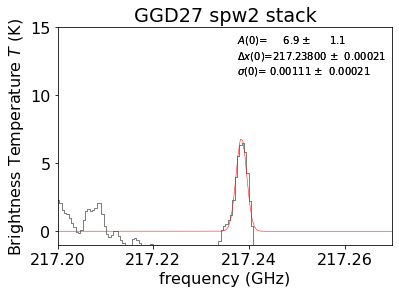

In [72]:
sp = stackspectra[2]
lx,ux = 217.2, 217.27
sp.plotter(xmin=lx, xmax=ux)
sp.baseline()
sp.plotter(xmin=lx, xmax=ux)
sp.specfit() #guesses=[5,216.935,0.01], limited=[(True,True),(True,True),(True,True)], limits=[(0,20),(216.93,216.94),(0.0001,0.05)])
sp.baseline(excludefit=True)
sp.plotter(xmin=lx, xmax=ux)
sp.specfit()
cen = sp.specfit.parinfo['SHIFT0']*sp.xarr.unit# * (1 + vcen/constants.c)
dx = (5*u.km/u.s / constants.c)*cen
Splatalogue.query_lines(cen-dx, cen+dx, line_lists=['CDMS'], energy_max=1000, energy_type='eu_k', chemical_name='DCN')
# DCN 217.238555

Species,Chemical Name,"Freq-GHz(rest frame,redshifted)","Freq Err(rest frame,redshifted)","Meas Freq-GHz(rest frame,redshifted)","Meas Freq Err(rest frame,redshifted)",Resolved QNs,CDMS/JPL Intensity,S<sub>ij</sub>&#956;<sup>2</sup> (D<sup>2</sup>),S<sub>ij</sub>,Log<sub>10</sub> (A<sub>ij</sub>),Lovas/AST Intensity,E_L (cm^-1),E_L (K),E_U (cm^-1),E_U (K),Upper State Degeneracy,Linelist
str19,str42,float64,float64,float64,float64,str28,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,str4
i-C3H7CN,iso-propyl cyanide,217.2938664,1.72e-05,--,--,"43(14,30)-43(11,32)",-6.1052,0.75485,0.0,-5.98458,--,244.754,352.1487,252.00214,362.57723,87.0,CDMS
50TiO2,Titanium dioxide,217.2940678,0.0031706,--,--,"40(8,32)-40(7,33)",-2.4089,1239.38802,0.0,-2.7382,--,461.421,663.87807,468.66915,674.30648,81.0,CDMS
NCC(O)NH2,Cyanoformamide,217.2943909,7.97e-05,--,--,"63(19,44)-62(20,43)",-4.6629,85.48313,7.266,-4.09484,--,590.4824,849.56757,597.73056,859.996,127.0,CDMS
13CN,Cyanide Radical,--,--,217.29447,8e-05,"N=2-1,J=5/2-3/2,F1=2-2,F=1-1",-4.0433,0.41293,0.196,-4.78416,--,3.6481,5.24877,10.89626,15.6772,3.0,CDMS
c-C6H5OH,Phenol,217.2946206,1.27e-05,--,--,"94(35,60)-93(36,57),v=0-1",-6.6961,42.57058,0.0,-5.04739,--,806.9895,1161.07942,814.23762,1171.50786,567.0,CDMS
DCCCHO,Propynal,217.2948186,4.66e-05,--,--,"25(14,11)-24(14,10)",-3.9368,95.4955,0.0,-3.6505,--,483.8649,696.17819,491.11307,706.60676,51.0,CDMS
DCCCHO,Propynal,217.2948186,4.66e-05,--,--,"25(14,12)-24(14,11)",-3.9368,95.4955,0.0,-3.6505,--,483.8649,696.17819,491.11307,706.60676,51.0,CDMS
"a-n-C3H7CN,v18=1","anti-n-butyronitrile, v<sub>18</sub> = 1",217.2948836,0.0027886,--,--,"90(4,87)-90(3,88)",-7.0099,39.60448,0.0,-4.58285,--,813.7262,1170.77811,820.97438,1181.20669,181.0,CDMS
C2H3OCHO,Vinyl formate,--,--,217.295093,2e-05,"37(3,35)-36(3,34)",-3.9652,44.37592,0.0,-4.15083,--,137.0414,197.17329,144.28958,207.60188,75.0,CDMS


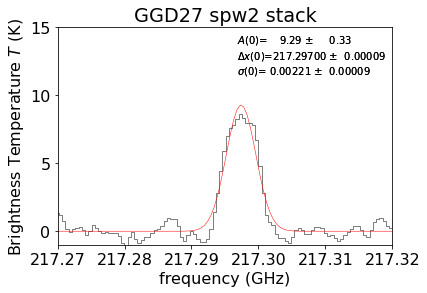

In [73]:
sp = stackspectra[2]
lx,ux = 217.27, 217.32
sp.plotter(xmin=lx, xmax=ux)
sp.baseline()
sp.plotter(xmin=lx, xmax=ux)
sp.specfit() #guesses=[5,216.935,0.01], limited=[(True,True),(True,True),(True,True)], limits=[(0,20),(216.93,216.94),(0.0001,0.05)])
sp.baseline(excludefit=True)
sp.plotter(xmin=lx, xmax=ux)
sp.specfit()
cen = sp.specfit.parinfo['SHIFT0']*sp.xarr.unit# * (1 + vcen/constants.c)
dx = (5*u.km/u.s / constants.c)*cen
Splatalogue.query_lines(cen-dx, cen+dx, line_lists=['CDMS'], energy_max=2000, energy_type='eu_k')
# 13CN or CaCl?

Species,Chemical Name,"Freq-GHz(rest frame,redshifted)","Freq Err(rest frame,redshifted)","Meas Freq-GHz(rest frame,redshifted)","Meas Freq Err(rest frame,redshifted)",Resolved QNs,CDMS/JPL Intensity,S<sub>ij</sub>&#956;<sup>2</sup> (D<sup>2</sup>),S<sub>ij</sub>,Log<sub>10</sub> (A<sub>ij</sub>),Lovas/AST Intensity,E_L (cm^-1),E_L (K),E_U (cm^-1),E_U (K),Upper State Degeneracy,Linelist
str4,str15,float64,float64,int64,int64,str23,float64,float64,float64,float64,str1,float64,float64,float64,float64,float64,str4
33SO,Sulfur Monoxide,217.8298337,1.6e-05,--,--,"6(5)-5(4), F=11/2-9/2",-2.9938,12.1659,5.163,-3.91375,b,16.833,24.21879,24.09902,34.67292,12.0,CDMS
33SO,Sulfur Monoxide,217.8317691,1.52e-05,--,--,"6(5)-5(4), F=13/2-11/2",-2.917,14.51909,6.162,-3.90389,b,16.8344,24.22081,24.10049,34.67502,14.0,CDMS
33SO,Sulfur Monoxide,217.8326422,1.78e-05,--,--,"6(5)-5(4), F=15/2-13/2",-2.842,17.25599,7.324,-3.88688,b,16.8362,24.2234,24.10231,34.67766,16.0,CDMS


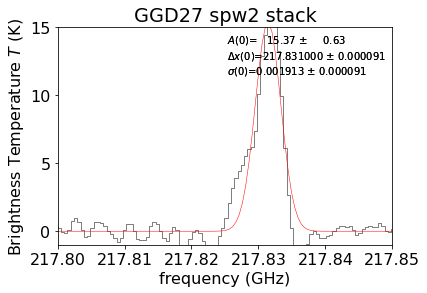

In [74]:
sp = stackspectra[2]
lx,ux = 217.8, 217.85
sp.plotter(xmin=lx, xmax=ux)
sp.baseline()
sp.plotter(xmin=lx, xmax=ux)
sp.specfit() #guesses=[5,216.935,0.01], limited=[(True,True),(True,True),(True,True)], limits=[(0,20),(216.93,216.94),(0.0001,0.05)])
sp.baseline(excludefit=True)
sp.plotter(xmin=lx, xmax=ux)
sp.specfit()
cen = sp.specfit.parinfo['SHIFT0']*sp.xarr.unit# * (1 + vcen/constants.c)
dx = (5*u.km/u.s / constants.c)*cen
Splatalogue.query_lines(cen-dx, cen+dx, line_lists=['CDMS'], energy_max=1000, energy_type='eu_k', chemical_name='Sulfur')
# 33SO 65-54

Species,Chemical Name,"Freq-GHz(rest frame,redshifted)","Freq Err(rest frame,redshifted)","Meas Freq-GHz(rest frame,redshifted)","Meas Freq Err(rest frame,redshifted)",Resolved QNs,CDMS/JPL Intensity,S<sub>ij</sub>&#956;<sup>2</sup> (D<sup>2</sup>),S<sub>ij</sub>,Log<sub>10</sub> (A<sub>ij</sub>),Lovas/AST Intensity,E_L (cm^-1),E_L (K),E_U (cm^-1),E_U (K),Upper State Degeneracy,Linelist
str11,str8,float64,float64,int64,int64,str25,float64,float64,float64,float64,int64,float64,float64,float64,float64,float64,str4
CH3OHvt=0-2,Methanol,217.886504,2.2e-05,--,--,"20(-1,19)-20(-0,20)E,vt=0",-4.1341,46.01891,0.0,-4.47128,--,346.0728,497.9187,353.34071,508.37554,164.0,CDMS


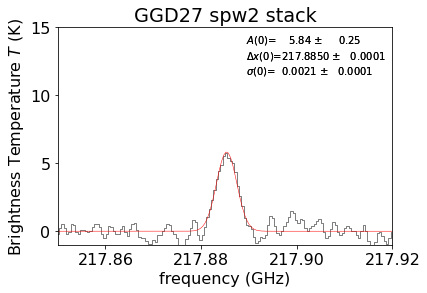

In [75]:
sp = stackspectra[2]
lx,ux = 217.85, 217.92
sp.plotter(xmin=lx, xmax=ux)
sp.baseline()
sp.plotter(xmin=lx, xmax=ux)
sp.specfit() #guesses=[5,216.935,0.01], limited=[(True,True),(True,True),(True,True)], limits=[(0,20),(216.93,216.94),(0.0001,0.05)])
sp.baseline(excludefit=True)
sp.plotter(xmin=lx, xmax=ux)
sp.specfit()
cen = sp.specfit.parinfo['SHIFT0']*sp.xarr.unit# * (1 + vcen/constants.c)
dx = (5*u.km/u.s / constants.c)*cen
Splatalogue.query_lines(cen-dx, cen+dx, line_lists=['CDMS'], energy_max=1000, energy_type='eu_k', chemical_name='Methanol')
# CH3OHvt=0-2	Methanol	217.886504	2.2e-05	--	--	20(-1,19)-20(-0,20)E,vt=0 ?

Species,Chemical Name,"Freq-GHz(rest frame,redshifted)","Freq Err(rest frame,redshifted)","Meas Freq-GHz(rest frame,redshifted)","Meas Freq Err(rest frame,redshifted)",Resolved QNs,CDMS/JPL Intensity,S<sub>ij</sub>&#956;<sup>2</sup> (D<sup>2</sup>),S<sub>ij</sub>,Log<sub>10</sub> (A<sub>ij</sub>),Lovas/AST Intensity,E_L (cm^-1),E_L (K),E_U (cm^-1),E_U (K),Upper State Degeneracy,Linelist
str4,str12,int64,int64,float64,float64,str13,float64,float64,float64,float64,int64,float64,float64,float64,float64,float64,str4
H2CO,Formaldehyde,--,--,218.222192,1e-05,"3(0,3)-2(0,2)",-2.769,16.308,3.0,-3.55007,--,7.2864,10.48344,14.56551,20.9564,7.0,CDMS


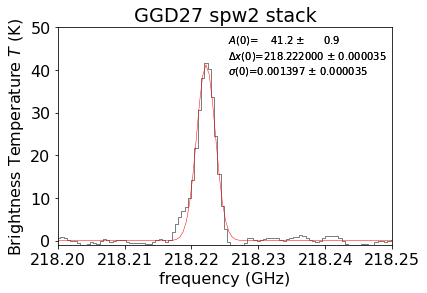

In [76]:
sp = stackspectra[2]
lx,ux = 218.2, 218.25
sp.plotter(xmin=lx, xmax=ux)
sp.baseline()
sp.plotter(xmin=lx, xmax=ux)
sp.specfit() #guesses=[5,216.935,0.01], limited=[(True,True),(True,True),(True,True)], limits=[(0,20),(216.93,216.94),(0.0001,0.05)])
sp.baseline(excludefit=True)
sp.plotter(xmin=lx, xmax=ux, ymax=50)
sp.specfit()
cen = sp.specfit.parinfo['SHIFT0']*sp.xarr.unit# * (1 + vcen/constants.c)
dx = (5*u.km/u.s / constants.c)*cen
Splatalogue.query_lines(cen-dx, cen+dx, line_lists=['CDMS'], energy_max=1000, energy_type='eu_k', chemical_name='Formaldehyde')
# H2CO

Species,Chemical Name,"Freq-GHz(rest frame,redshifted)","Freq Err(rest frame,redshifted)","Meas Freq-GHz(rest frame,redshifted)","Meas Freq Err(rest frame,redshifted)",Resolved QNs,CDMS/JPL Intensity,S<sub>ij</sub>&#956;<sup>2</sup> (D<sup>2</sup>),S<sub>ij</sub>,Log<sub>10</sub> (A<sub>ij</sub>),Lovas/AST Intensity,E_L (cm^-1),E_L (K),E_U (cm^-1),E_U (K),Upper State Degeneracy,Linelist
str7,str14,int64,int64,float64,float64,str7,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,str4
HC3Nv=0,Cyanoacetylene,--,--,218.324723,1e-05,J=24-23,-1.2947,334.19098,23.998,-3.08296,0.9,83.7551,120.50421,91.03763,130.98209,49.0,CDMS


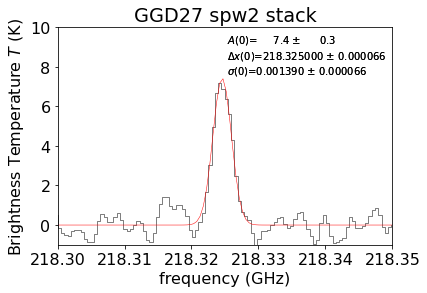

In [77]:
sp = stackspectra[2]
lx,ux = 218.3, 218.35
sp.plotter(xmin=lx, xmax=ux)
sp.baseline()
sp.plotter(xmin=lx, xmax=ux)
sp.specfit() #guesses=[5,216.935,0.01], limited=[(True,True),(True,True),(True,True)], limits=[(0,20),(216.93,216.94),(0.0001,0.05)])
sp.baseline(excludefit=True)
sp.plotter(xmin=lx, xmax=ux, ymax=10)
sp.specfit()
cen = sp.specfit.parinfo['SHIFT0']*sp.xarr.unit# * (1 + vcen/constants.c)
dx = (5*u.km/u.s / constants.c)*cen
Splatalogue.query_lines(cen-dx, cen+dx, line_lists=['CDMS'], energy_max=1000, energy_type='eu_k', chemical_name='HC3N')
# HC3Nv=0	Cyanoacetylene	--	--	218.324723	1e-05	J=24-23	

Species,Chemical Name,"Freq-GHz(rest frame,redshifted)","Freq Err(rest frame,redshifted)","Meas Freq-GHz(rest frame,redshifted)","Meas Freq Err(rest frame,redshifted)",Resolved QNs,CDMS/JPL Intensity,S<sub>ij</sub>&#956;<sup>2</sup> (D<sup>2</sup>),S<sub>ij</sub>,Log<sub>10</sub> (A<sub>ij</sub>),Lovas/AST Intensity,E_L (cm^-1),E_L (K),E_U (cm^-1),E_U (K),Upper State Degeneracy,Linelist
str11,str8,float64,float64,int64,int64,str21,float64,float64,float64,float64,int64,float64,float64,float64,float64,float64,str4
CH3OHvt=0-2,Methanol,218.440063,1.3e-05,--,--,"4(-2,3)-3(-1,2)E,vt=0",-3.9815,13.90508,0.0,-4.3292,--,24.3097,34.97603,31.59608,45.45944,36.0,CDMS


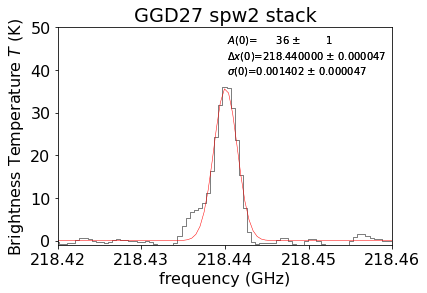

In [78]:
sp = stackspectra[2]
lx,ux = 218.42, 218.46
sp.plotter(xmin=lx, xmax=ux)
sp.baseline()
sp.plotter(xmin=lx, xmax=ux)
sp.specfit() #guesses=[5,216.935,0.01], limited=[(True,True),(True,True),(True,True)], limits=[(0,20),(216.93,216.94),(0.0001,0.05)])
sp.baseline(excludefit=True)
sp.plotter(xmin=lx, xmax=ux, ymax=50)
sp.specfit()
cen = sp.specfit.parinfo['SHIFT0']*sp.xarr.unit# * (1 + vcen/constants.c)
dx = (5*u.km/u.s / constants.c)*cen
Splatalogue.query_lines(cen-dx, cen+dx, line_lists=['CDMS'], energy_max=1000, energy_type='eu_k', chemical_name='Methanol')
# CH3OHvt=0-2	Methanol	218.440063	1.3e-05	--	--	4(-2,3)-3(-1,2)E,vt=0	

Species,Chemical Name,"Freq-GHz(rest frame,redshifted)","Freq Err(rest frame,redshifted)","Meas Freq-GHz(rest frame,redshifted)","Meas Freq Err(rest frame,redshifted)",Resolved QNs,CDMS/JPL Intensity,S<sub>ij</sub>&#956;<sup>2</sup> (D<sup>2</sup>),S<sub>ij</sub>,Log<sub>10</sub> (A<sub>ij</sub>),Lovas/AST Intensity,E_L (cm^-1),E_L (K),E_U (cm^-1),E_U (K),Upper State Degeneracy,Linelist
str4,str12,int64,int64,float64,float64,str13,float64,float64,float64,float64,int64,float64,float64,float64,float64,float64,str4
H2CO,Formaldehyde,--,--,218.475632,1e-05,"3(2,2)-2(2,1)",-3.0914,9.06195,1.667,-3.80373,--,40.0402,57.60858,47.32776,68.0937,7.0,CDMS


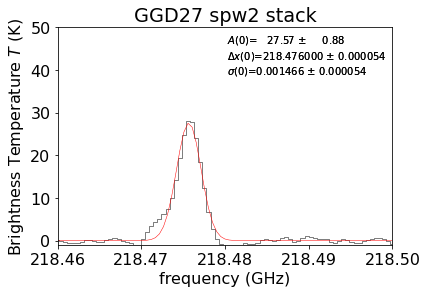

In [79]:
sp = stackspectra[2]
lx,ux = 218.46, 218.5
sp.plotter(xmin=lx, xmax=ux)
sp.baseline()
sp.plotter(xmin=lx, xmax=ux)
sp.specfit() #guesses=[5,216.935,0.01], limited=[(True,True),(True,True),(True,True)], limits=[(0,20),(216.93,216.94),(0.0001,0.05)])
sp.baseline(excludefit=True)
sp.plotter(xmin=lx, xmax=ux, ymax=50)
sp.specfit()
cen = sp.specfit.parinfo['SHIFT0']*sp.xarr.unit# * (1 + vcen/constants.c)
dx = (5*u.km/u.s / constants.c)*cen
Splatalogue.query_lines(cen-dx, cen+dx, line_lists=['CDMS'], energy_max=1000, energy_type='eu_k', chemical_name='Formaldehyde')
## H2CO

Species,Chemical Name,"Freq-GHz(rest frame,redshifted)","Freq Err(rest frame,redshifted)","Meas Freq-GHz(rest frame,redshifted)","Meas Freq Err(rest frame,redshifted)",Resolved QNs,CDMS/JPL Intensity,S<sub>ij</sub>&#956;<sup>2</sup> (D<sup>2</sup>),S<sub>ij</sub>,Log<sub>10</sub> (A<sub>ij</sub>),Lovas/AST Intensity,E_L (cm^-1),E_L (K),E_U (cm^-1),E_U (K),Upper State Degeneracy,Linelist
str4,str15,int64,int64,float64,float64,str3,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,str4
C18O,Carbon Monoxide,--,--,219.5603541,1.5e-06,2-1,-4.1794,0.0244,2.0,-6.22103,3.5,3.6619,5.26863,10.98565,15.8058,5.0,CDMS


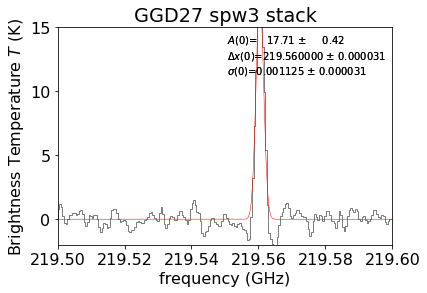

In [80]:
sp = stackspectra[1]
lx,ux = 219.5, 219.6
sp.plotter(xmin=lx, xmax=ux)
sp.baseline()
sp.plotter(xmin=lx, xmax=ux)
sp.specfit() #guesses=[5,216.935,0.01], limited=[(True,True),(True,True),(True,True)], limits=[(0,20),(216.93,216.94),(0.0001,0.05)])
sp.baseline(excludefit=True)
sp.plotter(xmin=lx, xmax=ux, ymax=15)
sp.specfit()
cen = sp.specfit.parinfo['SHIFT0']*sp.xarr.unit# * (1 + vcen/constants.c)
dx = (5*u.km/u.s / constants.c)*cen
Splatalogue.query_lines(cen-dx, cen+dx, line_lists=['CDMS'], energy_max=1000, energy_type='eu_k', chemical_name='Monoxide')
### C18O

Species,Chemical Name,"Freq-GHz(rest frame,redshifted)","Freq Err(rest frame,redshifted)","Meas Freq-GHz(rest frame,redshifted)","Meas Freq Err(rest frame,redshifted)",Resolved QNs,CDMS/JPL Intensity,S<sub>ij</sub>&#956;<sup>2</sup> (D<sup>2</sup>),S<sub>ij</sub>,Log<sub>10</sub> (A<sub>ij</sub>),Lovas/AST Intensity,E_L (cm^-1),E_L (K),E_U (cm^-1),E_U (K),Upper State Degeneracy,Linelist
str7,str14,int64,int64,float64,float64,str14,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,str4
HNCOv=0,Isocyanic Acid,--,--,219.73385,3e-05,"10(2,9)-9(2,8)",-2.8867,22.88527,8.917,-3.87104,0.6,151.3372,217.73922,158.66673,228.28472,21.0,CDMS
HNCOv=0,Isocyanic Acid,--,--,219.737193,3e-05,"10(2,8)-9(2,7)",-2.8867,22.8846,8.917,-3.87103,0.8,151.3374,217.73951,158.66704,228.28517,21.0,CDMS


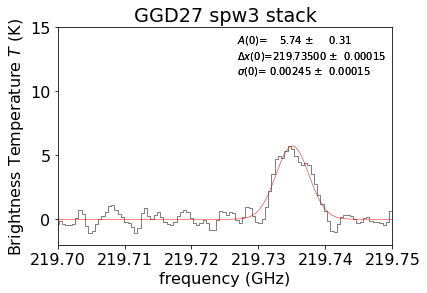

In [81]:
sp = stackspectra[1]
lx,ux = 219.7, 219.75
sp.plotter(xmin=lx, xmax=ux)
sp.baseline()
sp.plotter(xmin=lx, xmax=ux)
sp.specfit() #guesses=[5,216.935,0.01], limited=[(True,True),(True,True),(True,True)], limits=[(0,20),(216.93,216.94),(0.0001,0.05)])
sp.baseline(excludefit=True)
sp.plotter(xmin=lx, xmax=ux, ymax=15)
sp.specfit()
cen = sp.specfit.parinfo['SHIFT0']*sp.xarr.unit# * (1 + vcen/constants.c)
dx = (5*u.km/u.s / constants.c)*cen
Splatalogue.query_lines(cen-dx, cen+dx, line_lists=['CDMS'], energy_max=1000, energy_type='eu_k', chemical_name='Isocyanic')
### HNCOv=0	Isocyanic Acid	--	--	219.737193	3e-05	10(2,8)-9(2,7)	

Species,Chemical Name,"Freq-GHz(rest frame,redshifted)","Freq Err(rest frame,redshifted)","Meas Freq-GHz(rest frame,redshifted)","Meas Freq Err(rest frame,redshifted)",Resolved QNs,CDMS/JPL Intensity,S<sub>ij</sub>&#956;<sup>2</sup> (D<sup>2</sup>),S<sub>ij</sub>,Log<sub>10</sub> (A<sub>ij</sub>),Lovas/AST Intensity,E_L (cm^-1),E_L (K),E_U (cm^-1),E_U (K),Upper State Degeneracy,Linelist
str7,str14,int64,int64,float64,float64,str15,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,str4
HNCOv=0,Isocyanic Acid,--,--,219.798274,4e-06,"10(0,10)-9(0,9)",-2.6022,24.96404,9.727,-3.8329,0.3,32.994,47.47073,40.32568,58.01933,21.0,CDMS


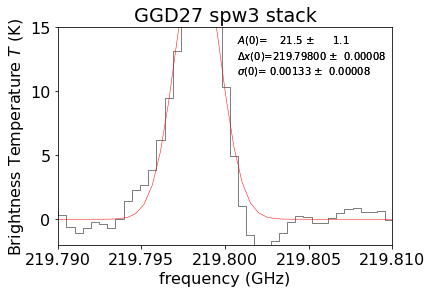

In [82]:
sp = stackspectra[1]
lx,ux = 219.79, 219.81
sp.plotter(xmin=lx, xmax=ux)
sp.baseline()
sp.plotter(xmin=lx, xmax=ux)
sp.specfit() #guesses=[5,216.935,0.01], limited=[(True,True),(True,True),(True,True)], limits=[(0,20),(216.93,216.94),(0.0001,0.05)])
sp.baseline(excludefit=True)
sp.plotter(xmin=lx, xmax=ux, ymax=15)
sp.specfit()
cen = sp.specfit.parinfo['SHIFT0']*sp.xarr.unit# * (1 + vcen/constants.c)
dx = (5*u.km/u.s / constants.c)*cen
Splatalogue.query_lines(cen-dx, cen+dx, line_lists=['CDMS'], energy_max=1000, energy_type='eu_k', chemical_name='Isocyanic')
# HNCOv=0	Isocyanic Acid	--	--	219.798274	4e-06	10(0,10)-9(0,9)	

Species,Chemical Name,"Freq-GHz(rest frame,redshifted)","Freq Err(rest frame,redshifted)","Meas Freq-GHz(rest frame,redshifted)","Meas Freq Err(rest frame,redshifted)",Resolved QNs,CDMS/JPL Intensity,S<sub>ij</sub>&#956;<sup>2</sup> (D<sup>2</sup>),S<sub>ij</sub>,Log<sub>10</sub> (A<sub>ij</sub>),Lovas/AST Intensity,E_L (cm^-1),E_L (K),E_U (cm^-1),E_U (K),Upper State Degeneracy,Linelist
str13,str15,int64,int64,float64,float64,str9,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,str4
SO3&Sigma;v=0,Sulfur Monoxide,--,--,219.949442,4e-05,6(5)-5(4),-2.3179,14.01468,5.948,-3.87446,4.3,16.979,24.42885,24.31572,34.9847,13.0,CDMS


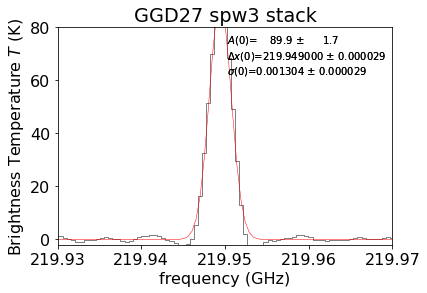

In [83]:
sp = stackspectra[1]
lx,ux = 219.93, 219.97
sp.plotter(xmin=lx, xmax=ux)
sp.baseline()
sp.plotter(xmin=lx, xmax=ux)
sp.specfit() #guesses=[5,216.935,0.01], limited=[(True,True),(True,True),(True,True)], limits=[(0,20),(216.93,216.94),(0.0001,0.05)])
sp.baseline(excludefit=True)
sp.plotter(xmin=lx, xmax=ux, ymax=80)
sp.specfit()
cen = sp.specfit.parinfo['SHIFT0']*sp.xarr.unit# * (1 + vcen/constants.c)
dx = (5*u.km/u.s / constants.c)*cen
Splatalogue.query_lines(cen-dx, cen+dx, line_lists=['CDMS'], energy_max=1000, energy_type='eu_k', chemical_name='Monoxide')
# SO

Species,Chemical Name,"Freq-GHz(rest frame,redshifted)","Freq Err(rest frame,redshifted)","Meas Freq-GHz(rest frame,redshifted)","Meas Freq Err(rest frame,redshifted)",Resolved QNs,CDMS/JPL Intensity,S<sub>ij</sub>&#956;<sup>2</sup> (D<sup>2</sup>),S<sub>ij</sub>,Log<sub>10</sub> (A<sub>ij</sub>),Lovas/AST Intensity,E_L (cm^-1),E_L (K),E_U (cm^-1),E_U (K),Upper State Degeneracy,Linelist
str11,str8,float64,float64,int64,int64,str21,float64,float64,float64,float64,int64,float64,float64,float64,float64,float64,str4
CH3OHvt=0-2,Methanol,220.078561,8e-06,--,--,"8(-0,8)-7(-1,6)E,vt=0",-4.0526,13.79045,0.0,-4.59926,--,59.8092,86.0516,67.15023,96.61365,68.0,CDMS


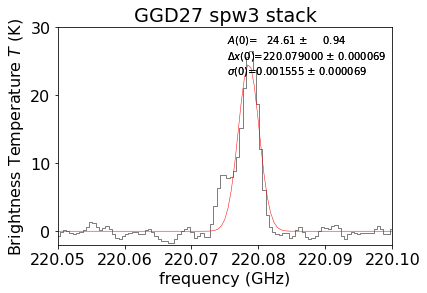

In [84]:
sp = stackspectra[1]
lx,ux = 220.05, 220.10
sp.plotter(xmin=lx, xmax=ux)
sp.baseline()
sp.plotter(xmin=lx, xmax=ux)
sp.specfit() #guesses=[5,216.935,0.01], limited=[(True,True),(True,True),(True,True)], limits=[(0,20),(216.93,216.94),(0.0001,0.05)])
sp.baseline(excludefit=True)
sp.plotter(xmin=lx, xmax=ux, ymax=30)
sp.specfit()
cen = sp.specfit.parinfo['SHIFT0']*sp.xarr.unit# * (1 + vcen/constants.c)
dx = (5*u.km/u.s / constants.c)*cen
Splatalogue.query_lines(cen-dx, cen+dx, line_lists=['CDMS'], energy_max=1000, energy_type='eu_k', chemical_name='Methanol')
# CH3OHvt=0-2	Methanol	220.078561	8e-06	--	--	8(-0,8)-7(-1,6)E,vt=0	

Species,Chemical Name,"Freq-GHz(rest frame,redshifted)","Freq Err(rest frame,redshifted)","Meas Freq-GHz(rest frame,redshifted)","Meas Freq Err(rest frame,redshifted)",Resolved QNs,CDMS/JPL Intensity,S<sub>ij</sub>&#956;<sup>2</sup> (D<sup>2</sup>),S<sub>ij</sub>,Log<sub>10</sub> (A<sub>ij</sub>),Lovas/AST Intensity,E_L (cm^-1),E_L (K),E_U (cm^-1),E_U (K),Upper State Degeneracy,Linelist
str7,str15,float64,float64,float64,float64,str15,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,str4
13COv=0,Carbon Monoxide,--,--,220.3986195,1.4e-06,"J=2-1,F=3/2-3/2",-5.3508,0.00325,0.266,-6.99442,17.0,3.6759,5.28877,11.02761,15.86617,4.0,CDMS
13COv=0,Carbon Monoxide,--,--,220.3986674,5e-07,"J=2-1,F=3/2-1/2",-4.6517,0.01624,1.331,-6.29532,17.0,3.6759,5.28877,11.02761,15.86618,4.0,CDMS
13COv=0,Carbon Monoxide,220.3986842,1e-07,--,--,2-1,-4.1749,0.04869,4.0,-6.51752,17.0,3.6759,5.28877,11.02761,15.86618,10.0,CDMS
13COv=0,Carbon Monoxide,--,--,220.3987006,1e-07,"J=2-1,F=5/2-3/2",-4.3967,0.02922,2.395,-6.21641,17.0,3.6759,5.28877,11.02761,15.86618,6.0,CDMS


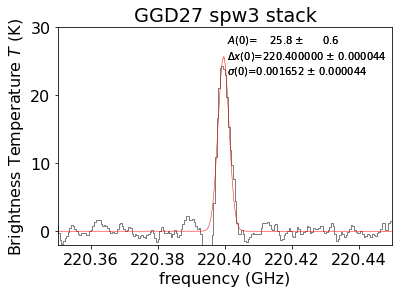

In [85]:
sp = stackspectra[1]
lx,ux = 220.35, 220.45
sp.plotter(xmin=lx, xmax=ux)
sp.baseline()
sp.plotter(xmin=lx, xmax=ux)
sp.specfit() #guesses=[5,216.935,0.01], limited=[(True,True),(True,True),(True,True)], limits=[(0,20),(216.93,216.94),(0.0001,0.05)])
sp.baseline(excludefit=True)
sp.plotter(xmin=lx, xmax=ux, ymax=30)
sp.specfit()
cen = sp.specfit.parinfo['SHIFT0']*sp.xarr.unit# * (1 + vcen/constants.c)
dx = (5*u.km/u.s / constants.c)*cen
Splatalogue.query_lines(cen-dx, cen+dx, line_lists=['CDMS'], energy_max=1000, energy_type='eu_k', chemical_name='Monoxide')
# 13CO

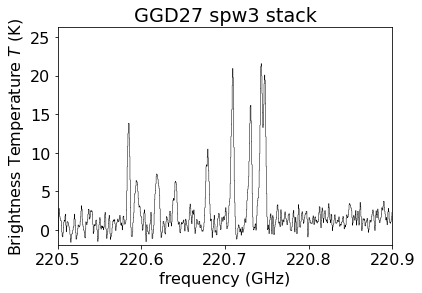

In [86]:
sp = stackspectra[1]
lx,ux = 220.5, 220.9
sp.plotter(xmin=lx, xmax=ux)
# CH3CN
#sp.baseline()
#sp.plotter(xmin=lx, xmax=ux)
#sp.specfit() #guesses=[5,216.935,0.01], limited=[(True,True),(True,True),(True,True)], limits=[(0,20),(216.93,216.94),(0.0001,0.05)])
#sp.baseline(excludefit=True)
#sp.plotter(xmin=lx, xmax=ux, ymax=30)
#sp.specfit()
#cen = sp.specfit.parinfo['SHIFT0']*sp.xarr.unit# * (1 + vcen/constants.c)
#dx = (5*u.km/u.s / constants.c)*cen
#Splatalogue.query_lines(cen-dx, cen+dx, line_lists=['CDMS'], energy_max=1000, energy_type='eu_k', chemical_name='Monoxide')
## 13CO

Species,Chemical Name,"Freq-GHz(rest frame,redshifted)","Freq Err(rest frame,redshifted)","Meas Freq-GHz(rest frame,redshifted)","Meas Freq Err(rest frame,redshifted)",Resolved QNs,CDMS/JPL Intensity,S<sub>ij</sub>&#956;<sup>2</sup> (D<sup>2</sup>),S<sub>ij</sub>,Log<sub>10</sub> (A<sub>ij</sub>),Lovas/AST Intensity,E_L (cm^-1),E_L (K),E_U (cm^-1),E_U (K),Upper State Degeneracy,Linelist
str11,str8,float64,float64,int64,int64,str20,float64,float64,float64,float64,int64,float64,float64,float64,float64,float64,str4
CH3OHvt=0-2,Methanol,231.28111,1.2e-05,--,--,"10(2,9)-9(3,6)A,vt=0",-4.2195,10.6823,0.0,-4.73726,--,107.2083,154.24794,114.92301,165.34762,84.0,CDMS


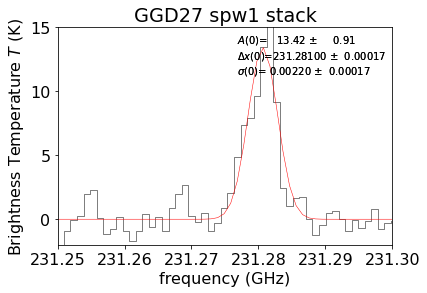

In [87]:
sp = stackspectra[3]
lx,ux = 231.25, 231.3
sp.plotter(xmin=lx, xmax=ux)
sp.baseline()
sp.plotter(xmin=lx, xmax=ux)
sp.specfit() #guesses=[5,216.935,0.01], limited=[(True,True),(True,True),(True,True)], limits=[(0,20),(216.93,216.94),(0.0001,0.05)])
sp.baseline(excludefit=True)
sp.plotter(xmin=lx, xmax=ux, ymax=15, ymin=-2)
sp.specfit()
cen = sp.specfit.parinfo['SHIFT0']*sp.xarr.unit# * (1 + vcen/constants.c)
dx = (5*u.km/u.s / constants.c)*cen
Splatalogue.query_lines(cen-dx, cen+dx, line_lists=['CDMS'], energy_max=1000, energy_type='eu_k', chemical_name='Methanol')
# CH3OH 10(2,9)-9(3,6)A,vt=0	

Species,Chemical Name,"Freq-GHz(rest frame,redshifted)","Freq Err(rest frame,redshifted)","Meas Freq-GHz(rest frame,redshifted)","Meas Freq Err(rest frame,redshifted)",Resolved QNs,CDMS/JPL Intensity,S<sub>ij</sub>&#956;<sup>2</sup> (D<sup>2</sup>),S<sub>ij</sub>,Log<sub>10</sub> (A<sub>ij</sub>),Lovas/AST Intensity,E_L (cm^-1),E_L (K),E_U (cm^-1),E_U (K),Upper State Degeneracy,Linelist
str11,str8,float64,float64,int64,int64,str20,float64,float64,float64,float64,int64,float64,float64,float64,float64,float64,str4
CH3OHvt=0-2,Methanol,232.418521,1.2e-05,--,--,"10(2,8)-9(3,7)A,vt=0",-4.2131,10.73599,0.0,-4.72869,--,107.2078,154.24722,114.96045,165.40149,84.0,CDMS
CH3OHvt=0-2,Methanol,232.4195,0.000484,--,--,"7(6,1)-7(7,0),vt=1",0.0,0.57214,0.0,-5.25383,--,448.967,645.96007,456.71968,657.11439,15.0,CDMS


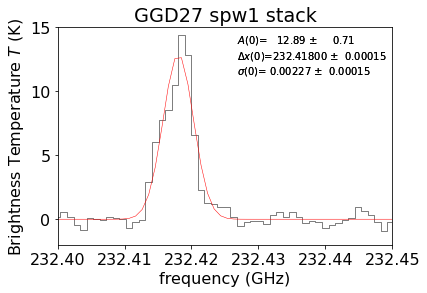

In [88]:
sp = stackspectra[3]
lx,ux = 232.4, 232.45
sp.plotter(xmin=lx, xmax=ux)
sp.baseline()
sp.plotter(xmin=lx, xmax=ux)
sp.specfit() #guesses=[5,216.935,0.01], limited=[(True,True),(True,True),(True,True)], limits=[(0,20),(216.93,216.94),(0.0001,0.05)])
sp.baseline(excludefit=True)
sp.plotter(xmin=lx, xmax=ux, ymax=15, ymin=-2)
sp.specfit()
cen = sp.specfit.parinfo['SHIFT0']*sp.xarr.unit# * (1 + vcen/constants.c)
dx = (5*u.km/u.s / constants.c)*cen
Splatalogue.query_lines(cen-dx, cen+dx, line_lists=['CDMS'], energy_max=1000, energy_type='eu_k', chemical_name='Methanol')
# Methanol  10(2,8)-9(3,7)A,vt=0	

Species,Chemical Name,"Freq-GHz(rest frame,redshifted)","Freq Err(rest frame,redshifted)","Meas Freq-GHz(rest frame,redshifted)","Meas Freq Err(rest frame,redshifted)",Resolved QNs,CDMS/JPL Intensity,S<sub>ij</sub>&#956;<sup>2</sup> (D<sup>2</sup>),S<sub>ij</sub>,Log<sub>10</sub> (A<sub>ij</sub>),Lovas/AST Intensity,E_L (cm^-1),E_L (K),E_U (cm^-1),E_U (K),Upper State Degeneracy,Linelist
str4,str15,int64,int64,float64,float64,str9,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,str4
S18O,Sulfur Monoxide,--,--,232.265835,0.0002,5(6)-4(5),-2.4121,11.38379,4.831,-3.82122,0.3,25.448,36.61378,33.19555,47.76072,11.0,CDMS


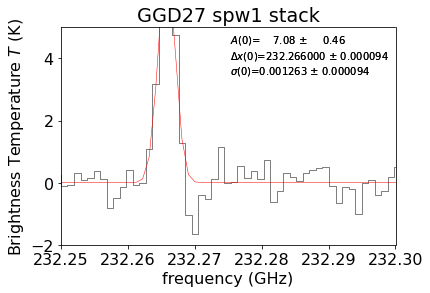

In [89]:
sp = stackspectra[3]
lx,ux = 232.25, 232.30
sp.plotter(xmin=lx, xmax=ux)
sp.baseline()
sp.plotter(xmin=lx, xmax=ux)
sp.specfit() #guesses=[5,216.935,0.01], limited=[(True,True),(True,True),(True,True)], limits=[(0,20),(216.93,216.94),(0.0001,0.05)])
sp.baseline(excludefit=True)
sp.plotter(xmin=lx, xmax=ux, ymax=5, ymin=-2)
sp.specfit()
cen = sp.specfit.parinfo['SHIFT0']*sp.xarr.unit# * (1 + vcen/constants.c)
dx = (5*u.km/u.s / constants.c)*cen
Splatalogue.query_lines(cen-dx, cen+dx, line_lists=['CDMS'], energy_max=1000, energy_type='eu_k', chemical_name='Monoxide')
# S18O 5(6)-4(5)	